## Manuscript Plots

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.ticker as mtick
from matplotlib.pyplot import figure
from matplotlib import collections  as mc
import matplotlib.lines as mlines


from tqdm import tnrange, tqdm_notebook

In [2]:
import os
import sys
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
from cvtk.plots import correction_diagnostic_plot, rep_plot_pca2, rep_plot_pca
from cvtk.bootstrap import bootstrap_ci, block_bootstrap
from cvtk.cov import stack_temporal_covariances

In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (6.0, 2.50)
mpl.rcParams['figure.dpi'] = 200

In [5]:
# image sizes
ONECOL = 3.42
THREEHALVESCOL = 4.5
TWOCOL = 7
plt.style.use('./buffalo.mplstyle')

## Barghi et al (2019) Combined Plots

In [88]:
barghi_gw_temp_covs_cis = np.load("../../data/barghi_et_al_2019/gw_temp_covs_cis.npy", allow_pickle=True)
barghi_g_cis_averep = np.load("../../data/barghi_et_al_2019/g_cis_averep.npy")
barghi_g = np.load("../../data/barghi_et_al_2019/g.npy")

In [89]:
def G_plot(g, g_averep_cis=None, alpha=1, point_alpha=1, linewidth=1, ax=None, 
           ylim=None, xlim=None, as_percent=True, hline=True, cmap=None, ci_col='0.2',
           rep_markersize=0, linestyle ='-'):
    if ax is None:
        fig, ax = plt.subplots()
    T, R = g.shape
    y_multiplier = 100. if as_percent else 1.
    x = np.arange(1, T+1) * 10
    cmap = cm.viridis if cmap is None else cmap
    cols = cmap(np.linspace(0, 1, T-1))
    for rep in range(R):
        for t in range(T-1):
            xa = x[t:(t+2)]
            mean = g[t:(t+2), rep]
            #import pdb; pdb.set_trace()
            ax.plot(xa, y_multiplier*mean, '-o', linewidth=linewidth, c=cols[t],
                    linestyle=linestyle,
                    alpha=alpha, zorder=-t, markersize=rep_markersize, solid_capstyle='round')  #markeredgecolor='w')
            ax.plot(xa, y_multiplier*mean, 'o', linewidth=linewidth, c=cols[t],
                    linestyle=linestyle,
                    alpha=point_alpha, zorder=-t, markersize=rep_markersize, solid_capstyle='round')#,  markeredgecolor='w')
            
    if g_averep_cis is not None:
        mean = g_averep_cis[1, :]
        lower, upper = g_averep_cis[0, :]-mean, mean-g_averep_cis[2, :]
        ax.plot(x, y_multiplier*mean, '-o', linewidth=linewidth, c=ci_col, markerfacecolor='w',
                zorder=1e4, markersize=2, linestyle=linestyle,)#, markeredgecolor='w', markeredgewidth=3)
        ax.errorbar(x, y_multiplier*mean, yerr=y_multiplier*np.column_stack([lower.ravel(), upper.ravel()]).T, 
                     capsize=0, elinewidth=linewidth*1.3, linewidth=0, linestyle=linestyle,
                     zorder=1e5, alpha=1, c=ci_col, label=None, solid_capstyle='round')
        ax.plot(x, y_multiplier*mean, 'o', linewidth=linewidth, c='k',
               zorder=np.Inf, markersize=2.1, linestyle=linestyle)
        

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-100, linestyle='--')

    ax.set_xlabel("generation ($t$)", fontsize=8.5, labelpad=-1)
    ax.set_ylabel("$G(t)$", fontsize=8)

In [90]:
def cov_plot(cov_cis, ax=None, alpha=1, error_alpha=1, ngens=1, linewidth=1, ylim=None, xlim=None, hline=True, 
             cmap=cm.Dark2, y_multiplier=None, xticks=None, linestyle='-', ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    _, T, T = cov_cis.shape
    y_multiplier = y_multiplier if y_multiplier is not None else 1
    mid_T = (T-4)/2
    for refgen in range(T):
        x = 2*ngens + np.arange(refgen, T) * ngens - mid_T + refgen*0.7  # TODO a bit of a hack
        mean = y_multiplier*cov_cis[1][refgen, (refgen+1):]
        lower, upper = y_multiplier*cov_cis[0][refgen, (refgen+1):]-mean, mean-y_multiplier*cov_cis[2][refgen, (refgen+1):]
        
        #ax.plot(np.broadcast_to(ngens*np.arange(refgen, T), (2, T-refgen)), temp_covs_bs[(0, 2), refgen, refgen:])
        ax.plot(x[:-1], mean, '-o', linewidth=linewidth, linestyle=linestyle, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
                label=refgen, zorder=refgen, markersize=2.5) #markersize=3.5)#, markeredgecolor='w')
        #ax.plot(x[:-1], mean, 'o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
        #        label=refgen, zorder=refgen) #markersize=4.3)# markeredgecolor='w')
        ax.errorbar(x[:-1], mean, yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
                    capsize=0, elinewidth=linewidth, c=cmap(refgen),  linestyle=linestyle, 
                    linewidth=0,
                    zorder=100+refgen, alpha=error_alpha, label=None, solid_capstyle='round')

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    #plt.xticks(np.arange(0, T*ngens, 10))
    if xticks is not None:
        plt.xticks(xticks)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1e6, linestyle='--')
    
    if ylab is None:
        ylab = "covariance"
        if y_multiplier is not None:
            ylab += f"  $(\\times 10^{{{int(np.log10(1/y_multiplier))}}})$"
        
#     ylab = "covariance "
#     if y_multiplier is not None:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"
#         ylab += f"  $ \\times 10^{{{int(np.log10(1/y_multiplier))}}}$"
#     add_latex = False
#     if add_latex:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"       
        
    ax.set_ylabel(ylab, fontsize=8.5)
    #plt.legend(loc=(0.02, 0.75))

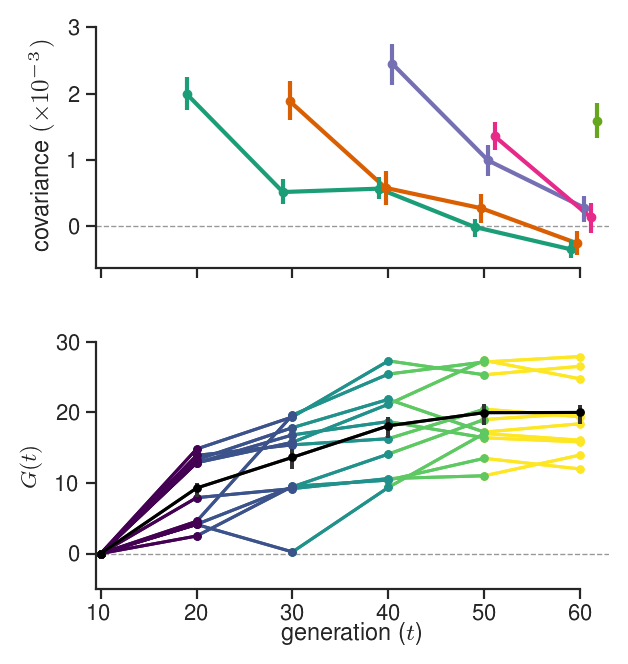

In [91]:
#plt.rc('text', usetex=False)
plt.rc('text', usetex=True)
plt.style.use('./buffalo.mplstyle')

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(ONECOL*1.5, ONECOL*1.1))

cov_plot(barghi_gw_temp_covs_cis, ax=ax[0], ngens=10, xlim=(9.5, 63), y_multiplier=1000, 
         linewidth=1.5, xticks=np.arange(0, 63, 10))
G_plot(barghi_g, barghi_g_cis_averep, ax=ax[1], xlim=(9.5, 63), ylim=(-5, 30),
       linewidth=1.1, alpha=1, rep_markersize=2)


# customize plots
#ax[0].spines['bottom'].set_bounds(10, 60)
#ax[0].spines['bottom'].set_bounds(9.7, 60)
#ax[0].spines['left'].set_bounds(-0.6, 2)
#ax[0].spines['left'].set_bounds(0, 2)  # end top y axis at 0
# this drops top y axis below 0
#ax[1].spines['left'].set_position(('axes', -0.01))
# this combines the top y axis with the x axis
#ax[0].spines['left'].set_position(('axes', 0.01))
#ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#ax[0].yaxis.set_major_formatter(mtick.LogFormatterMathtext())

#ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"${int(x)}\\%$"))

# uncomment if you don't want latex tick labels
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x)}%"))
# ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x}"))
ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x}"))
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x)}"))

ax[0].spines['bottom'].set_bounds(9.5, 60)
ax[1].spines['bottom'].set_bounds(9.5, 60)
ax[0].spines['left'].set_bounds(-0.63, 3)
ax[0].set_ylim(-0.63, 3.1)
ax[1].spines['left'].set_bounds(-5, 30)
#ax[1].spines['left'].set_bounds(-3, 20)
#ax[1].spines['left'].set_bounds(0, 20)

plt.subplots_adjust(wspace=0.3, hspace=0.3, left=.4)
fig.savefig("figure-1-G-covs.pdf", bbox_inches='tight')

In [10]:
barghi_g_cis_averep

array([[0.        , 0.09077539, 0.13285776, 0.17717126, 0.19559161,
        0.19562354],
       [0.        , 0.09278597, 0.13635574, 0.18102241, 0.19962738,
        0.19991532],
       [0.        , 0.09982357, 0.14461557, 0.1892272 , 0.20793592,
        0.20787397]])

### Figure 1 — without fixations

In [17]:
barghi_gw_temp_covs_cis_nofix = np.load("../../data/barghi_et_al_2019/gw_temp_covs_cis_nofix.npy")
barghi_g_cis_averep_nofix = np.load("../../data/barghi_et_al_2019/g_cis_averep_nofix.npy")
barghi_g_nofix = np.load("../../data/barghi_et_al_2019/g_nofix.npy")

In [18]:
barghi_g_cis_averep_nofix

array([[0.        , 0.04841922, 0.08019428, 0.12372535, 0.13423781,
        0.12571959],
       [0.        , 0.05360757, 0.08761598, 0.13195763, 0.14270023,
        0.1347244 ],
       [0.        , 0.05849804, 0.09304038, 0.13738435, 0.14833168,
        0.13941457]])

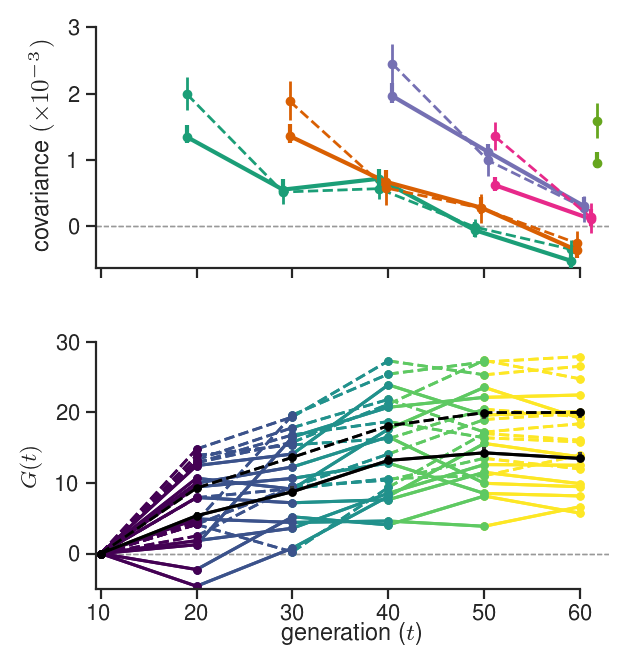

In [50]:
#plt.rc('text', usetex=False)
plt.rc('text', usetex=True)
plt.style.use('./buffalo.mplstyle')


fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(ONECOL*1.5, ONECOL*1.1))

# DASHED LINES ARE ORIGINAL FIGURE -- INCLUDES FIXED/LOST SITES`
cov_plot(barghi_gw_temp_covs_cis, ax=ax[0], ngens=10, xlim=(9.5, 63), y_multiplier=1000, 
         linewidth=1, xticks=np.arange(0, 63, 10), linestyle = '--')
G_plot(barghi_g, barghi_g_cis_averep, ax=ax[1], xlim=(9.5, 63), ylim=(-5, 30),
       linewidth=1, alpha=1, rep_markersize=2, linestyle = '--')


#fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(ONECOL*1.5, ONECOL*1.1))

cov_plot(barghi_gw_temp_covs_cis_nofix, ax=ax[0], ngens=10, xlim=(9.5, 63), y_multiplier=1000, 
         linewidth=1.5, xticks=np.arange(0, 63, 10))
G_plot(barghi_g_nofix, barghi_g_cis_averep_nofix, ax=ax[1], xlim=(9.5, 63), ylim=(-5, 30),
       linewidth=1.1, alpha=1, rep_markersize=2)


# customize plots
#ax[0].spines['bottom'].set_bounds(10, 60)
#ax[0].spines['bottom'].set_bounds(9.7, 60)
#ax[0].spines['left'].set_bounds(-0.6, 2)
#ax[0].spines['left'].set_bounds(0, 2)  # end top y axis at 0
# this drops top y axis below 0
#ax[1].spines['left'].set_position(('axes', -0.01))
# this combines the top y axis with the x axis
#ax[0].spines['left'].set_position(('axes', 0.01))
#ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#ax[0].yaxis.set_major_formatter(mtick.LogFormatterMathtext())

#ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"${int(x)}\\%$"))

# uncomment if you don't want latex tick labels
ax[1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x)}%"))
# ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x}"))
ax[1].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x}"))
ax[0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x)}"))

ax[0].spines['bottom'].set_bounds(9.5, 60)
ax[1].spines['bottom'].set_bounds(9.5, 60)
ax[0].spines['left'].set_bounds(-0.63, 3)
ax[0].set_ylim(-0.63, 3.1)
ax[1].spines['left'].set_bounds(-5, 30)
#ax[1].spines['left'].set_bounds(-3, 20)
#ax[1].spines['left'].set_bounds(0, 20)

plt.subplots_adjust(wspace=0.3, hspace=0.3, left=.4)
fig.savefig("figure-1-G-covs-nofix.pdf", bbox_inches='tight')

## Castro et al (2019)

In [71]:
castro_covs_cis = np.load("../../data/castro_et_al_2019/covs_bootstrap_10e6.npy")
castro_covs_sands_chr5_10_cis = np.load("../../data/castro_et_al_2019/covs_sans_chr5_and_chr10_bootstrap_10e6.npy")

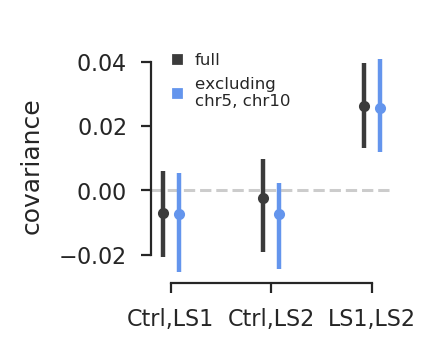

In [72]:
plt.style.use('buffalo.mplstyle')
plt.rc('text', usetex=False)

# get CIs for full data and subset (sans chr 5, 10)
mean = castro_covs_cis[1]
mean_subset = castro_covs_sands_chr5_10_cis[1]
mpl.rcParams['figure.figsize'] = (ONECOL/2.2, ONECOL/2.2)
#plt.figure(figsize=(5, 5))
lower, upper = castro_covs_cis[0]-mean, mean-castro_covs_cis[2]
lower_subset, upper_subset = castro_covs_sands_chr5_10_cis[0]-mean_subset, mean_subset-castro_covs_sands_chr5_10_cis[2]

#comps = [('cov($\Delta p_\mathrm{Ctrl}, \Delta p_\mathrm{LS1}$)', 0, 1), ('cov($\Delta p_\mathrm{Ctrl}, \Delta p_\mathrm{LS2}$)', 0, 2), ('cov($\Delta p_\mathrm{LS1}, \Delta p_\mathrm{LS2}$)', 1, 2)]
comps = [('Ctrl,LS1', 0, 1), 
         ('Ctrl,LS2', 0, 2), 
         ('LS1,LS2', 1, 2)]
# select out the right elements of covariance matrix for each comparision
means = [mean[r, c] for _, r, c in comps]
means_subset = [mean_subset[r, c] for _, r, c in comps]
bounds = np.stack([(lower[r, c], upper[r, c]) for _, r, c in comps]).T
bounds_subset = np.stack([(lower_subset[r, c], upper_subset[r, c]) for _, r, c in comps]).T
labels = [l for l, _, _ in comps]
  
fig, ax = plt.subplots()    
ax.axhline(y=0, c='k', alpha=0.2, linestyle='--', zorder=-1)
h1 = ax.errorbar(np.arange(3)-0.08, means, yerr=bounds, capsize=0, fmt='o', linewidth=2,
                 elinewidth=1.6, markersize=3, c='0.23', label='full')
h2 = ax.errorbar(np.arange(3)+0.08, means_subset, yerr=bounds_subset, capsize=0, fmt='o', alpha=1,
                linewidth=2, elinewidth=1.6, markersize=3, c='cornflowerblue', label='subset')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(labels)

gray_square = mlines.Line2D([], [], color='0.23', marker='s', linestyle='None',
                            markersize=3, label='full')
blue_square = mlines.Line2D([], [], color='cornflowerblue', marker='s', linestyle='None',
                            markersize=3, label='excluding \nchr5, chr10') 

ax.spines['left'].set_bounds(-0.02, 0.04)
ax.spines['bottom'].set_bounds(0, 2)
#ax.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('covariance', fontsize=9) #, fontsize=13)
ax.set_xlim(-0.2, 2.2)
#plt.xlabel('comparison')
#ax.set_xticklabels(labels, rotation = 45, ha="right")
plt.legend(handles=[gray_square, blue_square], loc=(-0.1, 0.6), prop={'size':6}, ncol=1, handletextpad=0.1)
plt.savefig('castro_rep_cis.pdf', bbox_inches="tight")


In [1163]:
castro_covs_cis

array([[[ 0.07777817, -0.01893739, -0.01577241],
        [-0.01893739,  0.10934695,  0.01307074],
        [-0.01577241,  0.01307074,  0.12341267]],

       [[ 0.10294169, -0.0069911 , -0.00235628],
        [-0.0069911 ,  0.13691365,  0.02631751],
        [-0.00235628,  0.02631751,  0.16493677]],

       [[ 0.11936342,  0.00654123,  0.01414081],
        [ 0.00654123,  0.15509356,  0.03939773],
        [ 0.01414081,  0.03939773,  0.19021948]]])

In [1164]:
castro_covs_sands_chr5_10_cis

array([[[ 0.07900582, -0.02040326, -0.02126141],
        [-0.02040326,  0.1035413 ,  0.01145699],
        [-0.02126141,  0.01145699,  0.12294405]],

       [[ 0.10678867, -0.00736898, -0.00733722],
        [-0.00736898,  0.13543516,  0.02544975],
        [-0.00733722,  0.02544975,  0.14899192]],

       [[ 0.12485804,  0.00861302,  0.01044781],
        [ 0.00861302,  0.15508946,  0.03846302],
        [ 0.01044781,  0.03846302,  0.16712265]]])

### Convergence Correlations 

A version of the above figure using convergence correlations.

In [67]:
castro_corrs_cis = np.load("../../data/castro_et_al_2019/all_conv_corrs.npy")
castro_corr_sans_chr5_10_cis = np.load("../../data/castro_et_al_2019/conv_corrs_sans_chr5_and_chr10.npy")

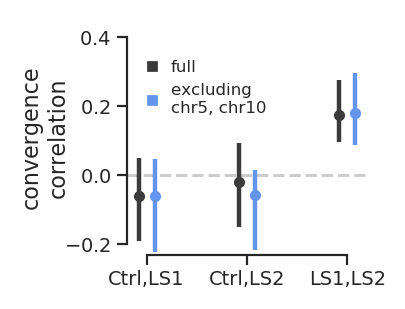

In [172]:
plt.style.use('buffalo.mplstyle')
plt.rc('text', usetex=False)

# get CIs for full data and subset (sans chr 5, 10)
means = castro_corrs_cis[1, :]
means_subset = castro_corr_sans_chr5_10_cis[1, :]
mpl.rcParams['figure.figsize'] = (ONECOL/2.2, ONECOL/2.2)
#plt.figure(figsize=(5, 5))
lower, upper = castro_corrs_cis[0, :]-means, means-castro_corrs_cis[2, :]
lower_subset, upper_subset = castro_corr_sans_chr5_10_cis[0, :]-means_subset, means_subset-castro_corr_sans_chr5_10_cis[2, :]

#comps = [('cov($\Delta p_\mathrm{Ctrl}, \Delta p_\mathrm{LS1}$)', 0, 1), ('cov($\Delta p_\mathrm{Ctrl}, \Delta p_\mathrm{LS2}$)', 0, 2), ('cov($\Delta p_\mathrm{LS1}, \Delta p_\mathrm{LS2}$)', 1, 2)]
comps = [('Ctrl,LS1', 0, 1), 
         ('Ctrl,LS2', 0, 2), 
         ('LS1,LS2', 1, 2)]
# select out the right elements of covariance matrix for each comparision
bounds = np.stack((lower, upper))
bounds_subset = np.stack((lower_subset, upper_subset))
labels = [l for l, _, _ in comps]
  
fig, ax = plt.subplots()    
ax.axhline(y=0, c='k', alpha=0.2, linestyle='--', zorder=-1)
h1 = ax.errorbar(np.arange(3)-0.08, means, yerr=bounds, capsize=0, fmt='o', linewidth=2,
                 elinewidth=1.6, markersize=3, c='0.23', label='full')
h2 = ax.errorbar(np.arange(3)+0.08, means_subset, yerr=bounds_subset, capsize=0, fmt='o', alpha=1,
                linewidth=2, elinewidth=1.6, markersize=3, c='cornflowerblue', label='subset')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(labels)

gray_square = mlines.Line2D([], [], color='0.23', marker='s', linestyle='None',
                            markersize=3, label='full')
blue_square = mlines.Line2D([], [], color='cornflowerblue', marker='s', linestyle='None',
                            markersize=3, label='excluding \nchr5, chr10') 

ax.spines['left'].set_bounds(-0.2, 0.4)
ax.spines['bottom'].set_bounds(0, 2)
#ax.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('convergence\ncorrelation', fontsize=8, labelpad=-2) #, fontsize=13)
ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.23, 0.45)
ax.tick_params(labelsize=7)
#plt.xlabel('comparison')
#ax.set_xticklabels(labels, rotation = 45, ha="right")
plt.legend(handles=[gray_square, blue_square], loc=(-0.1, 0.45), prop={'size':6}, ncol=1, handletextpad=0.1)
plt.savefig('castro_corr_cis.pdf', bbox_inches="tight")


## Kelly and Hughes (2019)

### Figure in original MS — covariancs

In [98]:
kh_covs_cis = np.load("../../data/kelly_hughes_2019/kelly_hughes_2019_covs_bootstrap.npy")

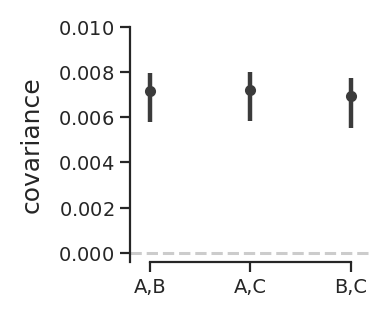

In [163]:
plt.style.use('buffalo.mplstyle')
plt.rc('text', usetex=False)

mean = kh_covs_cis[1]
mpl.rcParams['figure.figsize'] = (ONECOL/2.2, ONECOL/2.2)
#plt.figure(figsize=(5, 5))
lower, upper = kh_covs_cis[0]-mean, mean-kh_covs_cis[2]
comps = [('A,B', 0, 1), 
         ('A,C', 0, 2), 
         ('B,C', 1, 2)]
means = [mean[r, c] for _, r, c in comps]
bounds = np.stack([(lower[r, c], upper[r, c]) for _, r, c in comps]).T
labels = [l for l, _, _ in comps]
  
ax = plt.subplot()
ax.errorbar(labels, means, yerr=bounds, capsize=0, fmt='o', linewidth=2, elinewidth=1.6, markersize=3, c='0.23')
ax.axhline(y=0, c='k', alpha=0.2, linestyle='--')


#ax.spines['left'].set_bounds(-0.02, 0.04)
ax.spines['bottom'].set_bounds(-0, 2)
ax.spines['left'].set_bounds(-0.0004, 0.01)
#ax.tick_params(axis='both', which='major', labelsize=10)
#plt.ylabel('covariance', fontsize=13)
ax.set_ylim(-0.0004, 0.01)
ax.set_xlim(-0.2, 2.2)
plt.ylabel('covariance', fontsize=9)
ax.tick_params(labelsize=7)
#plt.xlabel('comparison')
#ax.set_xticklabels(labels, rotation = 45, ha="right")
#plt.savefig('castro_rep_cis.pdf', bbox_inches="tight")
plt.savefig('kh_rep_cis.pdf', bbox_inches="tight")



### Figure in revised MS — convergence correlations

In [173]:
kh_all_corrs_cis = np.load("../../data/kelly_hughes_2019/kelly_hughes_2019_all_conv_corr_cis.npy")

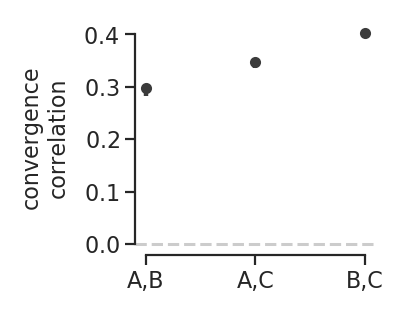

In [174]:
plt.style.use('buffalo.mplstyle')
plt.rc('text', usetex=False)

means = kh_all_corrs_cis[1, :]
mpl.rcParams['figure.figsize'] = (ONECOL/2.2, ONECOL/2.2)
#plt.figure(figsize=(5, 5))
lower, upper = kh_all_corrs_cis[0, :] - means, means - kh_all_corrs_cis[2, :]
comps = [('A,B', 0, 1), 
         ('A,C', 0, 2), 
         ('B,C', 1, 2)]
bounds = np.stack((lower, upper))
labels = [l for l, _, _ in comps]
  
ax = plt.subplot()
ax.errorbar(labels, means, yerr=bounds, capsize=0, fmt='o', linewidth=2, elinewidth=1.6, markersize=3, c='0.23')
ax.axhline(y=0, c='k', alpha=0.2, linestyle='--')


#ax.spines['left'].set_bounds(-0.02, 0.04)
ax.spines['bottom'].set_bounds(-0, 2)
ax.spines['left'].set_bounds(0, 0.4)
#ax.tick_params(axis='both', which='major', labelsize=10)
#plt.ylabel('covariance', fontsize=13)
#ax.set_ylim(-0.0004, 0.01)
#ax.set_xlim(-0.2, 2.2)
plt.ylabel('convergence\ncorrelation', fontsize=8)
ax.tick_params(labelsize=8)
#plt.xlabel('comparison')
#ax.set_xticklabels(labels, rotation = 45, ha="right")
#plt.savefig('castro_rep_cis.pdf', bbox_inches="tight")
plt.savefig('kh_rep_corrs_cis.pdf', bbox_inches="tight")



Confidence intervals in paper:

In [14]:
np.round(kh_covs_cis[:, (0, 0, 1), (1, 2, 2)], 5)

array([[0.00637, 0.0064 , 0.00613],
       [0.00718, 0.0072 , 0.00693],
       [0.00859, 0.00857, 0.00836]])

### Barghi Convergence Correlation Plot

In [128]:
barghi_conv_corr_cis = np.load("../../data/barghi_et_al_2019/barghi_et_al_2019_conv_corr_cis.npy")[:, 0, ...]

In [176]:
def convcorr_plot(cov_cis, ax=None, alpha=1, error_alpha=1, ngens=1, linewidth=1, ylim=None, xlim=None, hline=True, 
             cmap=cm.Dark2, y_multiplier=None, xticks=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    _, T, T = cov_cis.shape
    y_multiplier = y_multiplier if y_multiplier is not None else 1
    mid_T = (T-4)/2
    for refgen in range(T):
        x = ngens + np.arange(refgen, T) * ngens - mid_T + refgen*0.7  # TODO a bit of a hack
        mean = y_multiplier*cov_cis[1][refgen, refgen:]
        lower, upper = y_multiplier*cov_cis[0][refgen, refgen:]-mean, mean-y_multiplier*cov_cis[2][refgen, refgen:]
        
        #ax.plot(np.broadcast_to(ngens*np.arange(refgen, T), (2, T-refgen)), temp_covs_bs[(0, 2), refgen, refgen:])
        ax.plot(x, mean, '-o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
                label=refgen, zorder=refgen, markersize=2.) #, markersize=3., markeredgecolor='w')
        #ax.plot(x, mean, 'o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
        #        label=refgen, zorder=refgen) #, markersize=3.5, markeredgecolor='w')
        ax.errorbar(x, mean, yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
                    capsize=0, elinewidth=linewidth, c=cmap(refgen), 
                    linewidth=0,
                    zorder=refgen, alpha=error_alpha, label=None, solid_capstyle='round')

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    #plt.xticks(np.arange(0, T*ngens, 10))
    if xticks is not None:
        plt.xticks(xticks)
    if hline:
        ax.axhline(y=0, c='k', alpha=0.2, zorder=-1e6, linestyle='--')
    
    if ylab is None:
        ylab = "covariance"
        if y_multiplier is not None:
            ylab += f"  $(\\times 10^{{{int(np.log10(1/y_multiplier))}}})$"
        
#     ylab = "covariance "
#     if y_multiplier is not None:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"
#         ylab += f"  $ \\times 10^{{{int(np.log10(1/y_multiplier))}}}$"
#     add_latex = False
#     if add_latex:
#         ylab += "\n $\\mathrm{cov}(\\Delta p_s, \\Delta p_t)$"       
        
    ax.set_ylabel(ylab)
    #plt.legend(loc=(0.02, 0.75))

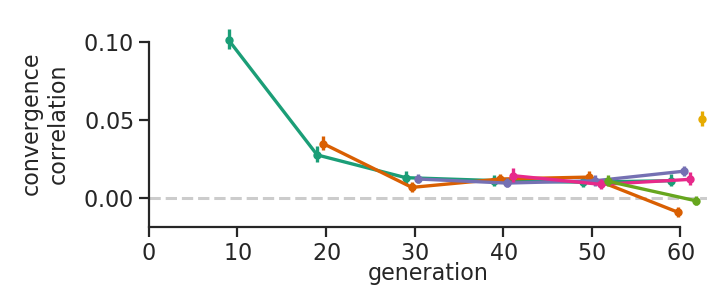

In [177]:
plt.style.use('buffalo.mplstyle')

fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(THREEHALVESCOL*0.8, ONECOL/2.5))

convcorr_plot(barghi_conv_corr_cis, ax=ax, ngens=10, xlim=(9.5, 63), y_multiplier=None, linewidth=1.2,
              xticks=np.arange(0, 63, 10), ylab='convergence\ncorrelation')

ax.set_xlabel("generation", fontsize=8, labelpad=-1)
ax.set_ylabel("convergence\ncorrelation", fontsize=8)


ax.spines['left'].set_bounds(-0.018, 0.1)
ax.spines['bottom'].set_bounds(0, 60)
fig.savefig("figure-2-corr.pdf", bbox_inches='tight')

In the paper, we mention the bootstrap CIs for the first timepoint; these are:

In [488]:
barghi_conv_corr_cis[:, 0, 0]

array([0.09428963, 0.10111382, 0.10666285])

Twenty generations later:

In [492]:
barghi_conv_corr_cis[:, 2, 2]

array([0.00871028, 0.0121614 , 0.01494563])

## Barghi et al (2019) Empirical Null

In [ ]:
barghi_emp_null_tile = np.load('../../data/barghi_et_al_2019/empnull_tile_1e5.npy')
barghi_emp_null_seqid = np.load('../../data/barghi_et_al_2019/empnull_seqid_1e5.npy')
barghi_tile_covs = np.load('../../data/barghi_et_al_2019/tile_temporal_covs_1e5.npy')

### Cross-validating Binsize

In [272]:
nbins = np.arange(10, 200, 10)

def histogram_risk(data, bins):
    assert(data.ndim == 1)
    densities, bins = np.histogram(data, bins, density=True)
    phat = densities * np.diff(bins)
    np.testing.assert_almost_equal(phat.sum(), 1)
    n = data.shape[0]
    h = np.diff(bins).mean()
    return 2 / (h*n-h) - (n+1)/(h*n-h) * (phat**2).sum()

def estimated_cv_risk(data, ns, xmin, xmax, progress=True):
    risks = []
    ns_range = tqdm_notebook(ns) if progress else ns
    for n in ns_range:
        bins = np.linspace(xmin, xmax, n)
        risks.append(histogram_risk(data, bins))
    return ns, np.array(risks)

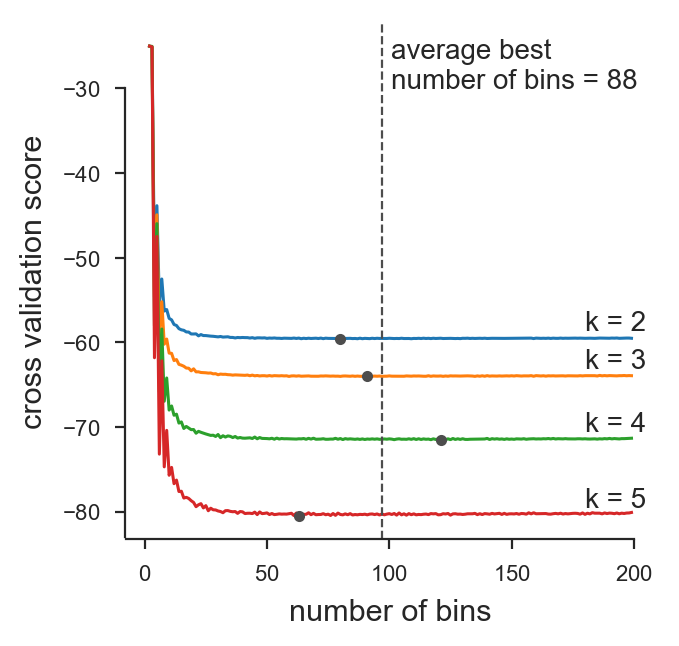

In [342]:
all_risks, best_nbins = dict(), dict()
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(ONECOL, ONECOL))

for offset in np.arange(2, 6):
    tile_covs = np.diagonal(barghi_tile_covs, offset, axis1=1, axis2=2).ravel()
    nbins, risks = estimated_cv_risk(tile_covs, np.arange(2, 200, 1), -0.02, 0.02)
    all_risks[offset] = nbins, risks
    best_nbins[offset] = nbins[np.argmin(risks)]
    ax.plot(nbins, risks)
    best_risk = risks[np.argmin(risks)]
    ax.plot(best_nbins[offset], best_risk, 'o', c='0.3', markersize=3) 
    ax.text(180, best_risk+1, f"k = {offset}")
#ax.set_ylim(-60, -55)

BEST_NBINS = np.floor(np.array(list(best_nbins.values())).mean())
ax.axvline(best_nbin, c='0.3', linestyle='--', linewidth=0.8)
ax.text(best_nbin*1.04, -30, f"average best \nnumber of bins = {int(BEST_NBINS)}")
ax.spines['left'].set_bounds(-83, -30)
ax.spines['bottom'].set_bounds(-7.5, 200)
ax.set_ylabel('cross validation score')
ax.set_xlabel('number of bins')
fig.savefig("barghi-cross-validation-binsize.pdf", bbox_inches='tight')


#### Sign-permutation histogram

In [22]:
plt.rc('text', usetex=False)

def cov_hist(empnull, real, rep=None, k=2, bins=np.linspace(-0.03, 0.03, 15), alpha=0.4,
             ax=None, fontsize=10,
             empnull_label='sign-permuted\nneutral null', real_label='observed covariance',
             xlabel='covariance', ylabel='density'):
    assert(empnull.ndim == 5)
    rep = slice(None) if rep is None else rep
    # empnull is npermutations x nblocks x T x T x R
    # real is nblocks x T x T x R
    # after extracting diagonal, empnull_covs is npermutations x nblocks x R x U where U is elements
    # among diagonal k
    empnull_covs = np.diagonal(empnull, offset=k, axis1=2, axis2=3)[:, :, rep, :].ravel()
    real_covs = np.diagonal(real, offset=k, axis1=1, axis2=2)[:, rep, :].ravel()
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(empnull_covs, bins, alpha=alpha, density=True, label=empnull_label)
    ax.hist(real_covs, bins, alpha=alpha, density=True, label=real_label)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    return ax

/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


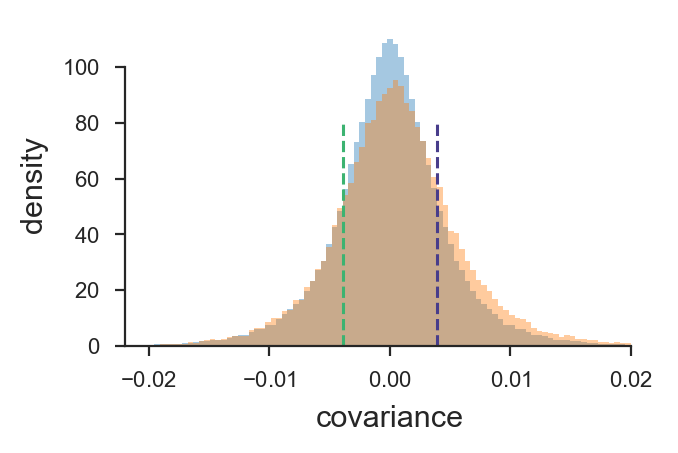

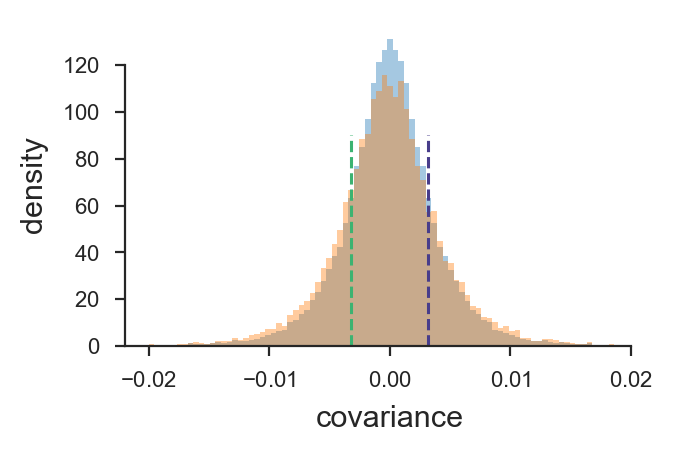

In [1106]:
alpha = 0.2
upper_tail_color='darkslateblue'
lower_tail_color='mediumseagreen'

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/1.6))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=2, rep=None, 
         ax=ax, bins=np.linspace(-0.02, 0.02, BEST_NBINS),
         fontsize=11)

upper_tail, lower_tail = np.nanquantile(np.diagonal(barghi_emp_null_seqid, 2, 2, 3), (alpha, 1-alpha))
tail_segments = [[(lower_tail, 0), (lower_tail, 80)],
                 [(upper_tail, 0), (upper_tail, 80)]]
#ax.axvline(upper_tail, c=upper_tail_color)
#ax.axvline(lower_tail, c=lower_tail_color)
lc = mc.LineCollection(tail_segments, colors=(upper_tail_color, lower_tail_color), linestyle='--')
ax.add_collection(lc)
ax.spines['left'].set_bounds(0, 100)
ax.spines['bottom'].set_bounds(-0.022, 0.020)
fig.savefig("figure-3-hists-a.pdf", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/1.6))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=4, rep=None, 
         ax=ax, bins=np.linspace(-0.02, 0.02, BEST_NBINS),
         fontsize=11)
upper_tail, lower_tail = np.nanquantile(np.diagonal(barghi_emp_null_seqid, 4, 2, 3), (alpha, 1-alpha))
#ax.legend(loc=(0.8,0.5))
tail_segments = [[(lower_tail, 0), (lower_tail, 90)],
                 [(upper_tail, 0), (upper_tail, 90)]]
#ax.axvline(upper_tail, c=upper_tail_color)
#ax.axvline(lower_tail, c=lower_tail_color)
lc = mc.LineCollection(tail_segments, colors=(upper_tail_color, lower_tail_color), linestyle='--')
ax.add_collection(lc)
ax.spines['left'].set_bounds(0, 120)
ax.spines['bottom'].set_bounds(-0.022, 0.020)
fig.savefig("figure-3-hists-b.pdf", bbox_inches='tight')
#ax[1].text(-0.02, 240, "permuted tile blocks")

### Sign-Permutation without fixations

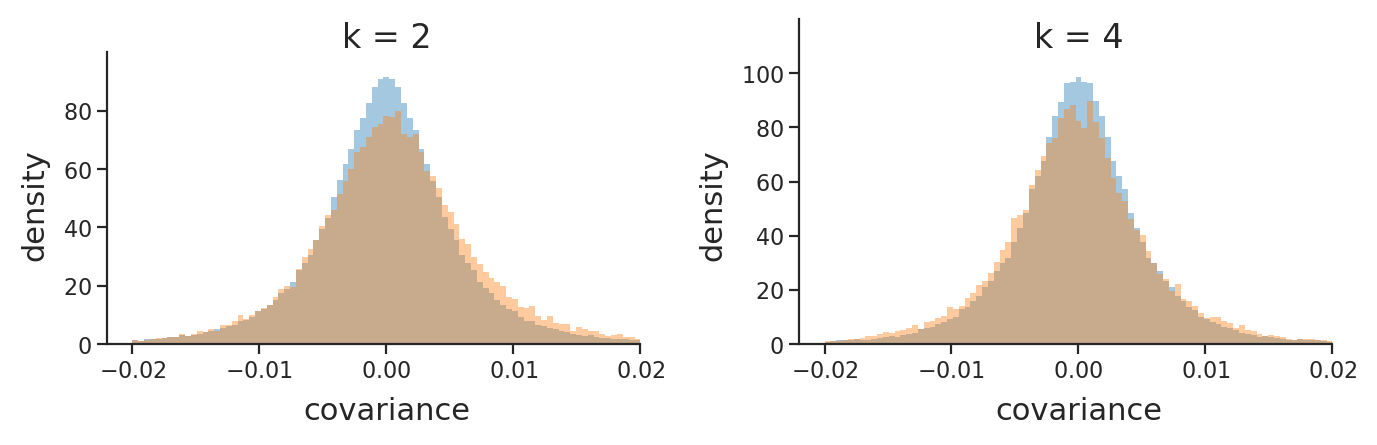

In [72]:
barghi_emp_null_tile_wof = np.load('../../data/barghi_et_al_2019/empnull_tile_1e5_without_fixations.npy')
barghi_tile_covs_wof = np.load('../../data/barghi_et_al_2019/tile_temporal_covs_1e5_without_fixations.npy')
BEST_NBINS = 88

alpha = 0.2
upper_tail_color='darkslateblue'
lower_tail_color='mediumseagreen'

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(TWOCOL, ONECOL*0.7))
cov_hist(barghi_emp_null_tile_wof, barghi_tile_covs_wof, k=2, rep=None, 
         ax=axs[0], bins=np.linspace(-0.02, 0.02, BEST_NBINS),
         fontsize=11)

upper_tail, lower_tail = np.nanquantile(np.diagonal(barghi_emp_null_tile_wof, 2, 2, 3), (alpha, 1-alpha))
tail_segments = [[(lower_tail, 0), (lower_tail, 80)],
                 [(upper_tail, 0), (upper_tail, 80)]]
#ax.axvline(upper_tail, c=upper_tail_color)
#ax.axvline(lower_tail, c=lower_tail_color)
#lc = mc.LineCollection(tail_segments, colors=(upper_tail_color, lower_tail_color), linestyle='--')
#ax.add_collection(lc)
axs[0].spines['left'].set_bounds(0, 100)
axs[0].spines['bottom'].set_bounds(-0.022, 0.020)

#fig, axs = plt.subplots(figsize=(ONECOL, ONECOL/1.6))
cov_hist(barghi_emp_null_tile_wof, barghi_tile_covs, k=4, rep=None, 
         ax=axs[1], bins=np.linspace(-0.02, 0.02, BEST_NBINS),
         fontsize=11)
upper_tail, lower_tail = np.nanquantile(np.diagonal(barghi_emp_null_tile_wof, 4, 2, 3), (alpha, 1-alpha))
#ax.legend(loc=(0.8,0.5))
tail_segments = [[(lower_tail, 0), (lower_tail, 90)],
                 [(upper_tail, 0), (upper_tail, 90)]]
#ax.axvline(upper_tail, c=upper_tail_color)
#ax.axvline(lower_tail, c=lower_tail_color)
#lc = mc.LineCollection(tail_segments, colors=(upper_tail_color, lower_tail_color), linestyle='--')
#ax.add_collection(lc)
axs[1].spines['left'].set_bounds(0, 120)
axs[1].spines['bottom'].set_bounds(-0.022, 0.020)
axs[0].set_title('k = 2')
axs[1].set_title('k = 4')
plt.tight_layout()
fig.savefig("figure-3-hists-b-without-fixations.pdf", bbox_inches='tight')
#ax[1].text(-0.02, 240, "permuted tile blocks")

### P-value calculation

This pools all replicates.

In [305]:
def calc_tail_probs(empnull, real, alpha=0.01):
    tails = np.nanquantile(empnull, (alpha, 1-alpha))
    lt, rt = np.nanmean(real < tails[0]), np.nanmean(real > tails[1])
    return np.array([lt, rt])

def bootstrap_tail_probs(empnull, real, B=1000, alpha=0.01, progress_bar=False):
    nperms, nblocks, T, T_, R = empnull.shape
    straps = []
    B_range = tnrange(B) if progress_bar else np.arange(B)
    # pre-cache all of the elements along each diagonal.
    real_ks = {k: np.diagonal(real, offset=k, axis1=1, axis2=2) for k in np.arange(1, T)}
    empnull_ks = {k: np.swapaxes(np.diagonal(empnull, offset=k, axis1=2, axis2=3), 0, 1) for k in np.arange(1, T)}
    for b in B_range:
        bidx = np.random.randint(0, nblocks, size=nblocks)
        #import pdb; pdb.set_trace()
        straps.append([calc_tail_probs(empnull_ks[k][bidx,:  :, :], real_ks[k], alpha=alpha) for k in np.arange(1, T)])
    return straps

def plot_tail_probs(tail_prob_cis, ax=None, alpha=0.01, fontsize=11,
                    upper_tail_color='darkslateblue', lower_tail_color='mediumseagreen'):
    mean = tail_prob_cis[1]
    lower, upper = tail_prob_cis[0] - mean, mean - tail_prob_cis[2]
    k = np.arange(2, 6)
    if ax is None:
        fig, ax = plt.subplots()
    ax.errorbar(k+0.05, mean[:, 0], np.stack((lower[:, 0], upper[:, 0])),
                label='left', fmt='-o', markersize=2.8, linewidth=1.6,
                linestyle='--', c=lower_tail_color)
    ax.errorbar(k-0.05, mean[:, 1], np.stack((lower[:, 1], upper[:, 1])),
                label='right', fmt='-o', markersize=2.8, linewidth=1.6,
                linestyle='--', c=upper_tail_color)
    ax.set_xticks(k)
    ax.axhline(y=alpha, c='k', alpha=0.2, linestyle='--', zorder=-1)
    ax.set_xlabel('k', fontsize=fontsize)
    ax.set_ylabel(f'{int(100*alpha)}% tail prob', fontsize=fontsize)
    return ax


### Barghi Tail Probabilities Bootstraps — Window-level Permutations

In [306]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.5]

empnull_tail_probs_bootstraps = dict()
for alpha in alphas:
    FILENAME = f'../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_{alpha}.npy'
    if not os.path.exists(FILENAME):
        print(f"bootstrapping for {FILENAME}")
        empnull_tail_probs_bootstraps[alpha] = np.array(bootstrap_tail_probs(barghi_emp_null_tile, barghi_tile_covs,
                                                                             B=1000, alpha=alpha, progress_bar=True))
        with open(FILENAME, 'wb') as f:
            np.save(f, empnull_tail_probs_bootstraps[alpha])
    else:
         with open(FILENAME, 'rb') as f:
            print(f"loading bootstraps for {FILENAME}")
            empnull_tail_probs_bootstraps[alpha] = np.load(f)

loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.01.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.05.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.1.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.2.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.5.npy


In [307]:
T = 6

# estimate the tail probabilities for each k
tail_probs = dict()
for alpha in alphas:
    probs = []
    for k in np.arange(1, T):
        emp_null_covs = np.diagonal(barghi_emp_null_tile, k, 2, 3)
        obs_covs = np.diagonal(barghi_tile_covs, k, 1, 2)
        probs.append(calc_tail_probs(emp_null_covs, obs_covs, alpha=alpha))
    tail_probs[alpha] = np.array(probs)

### Barghi Empirical Tail Probabilities for α=0.01

The tail probabilities start at k=1, the bias-corrected off diagonal — the permutation procedure does not account for this, so we don't plot it.

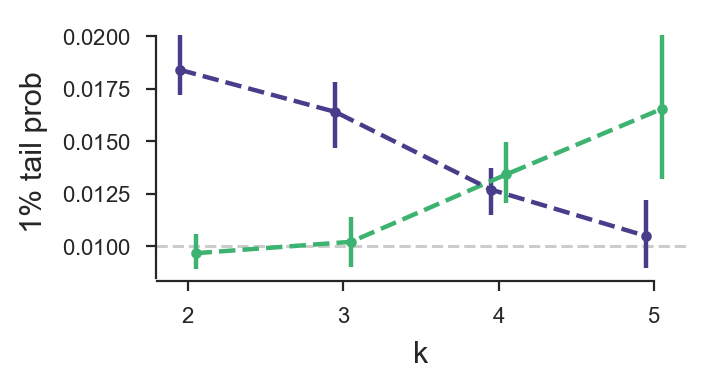

In [539]:
tail_probs_cis_01 = bootstrap_ci(tail_probs[0.01], empnull_tail_probs_bootstraps[0.01])

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_01[:, 1:, :], ax=ax, alpha=0.01)
ax.spines['left'].set_bounds(0.0085, 0.02)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("barghi-tailprobs-0.01.pdf", bbox_inches='tight')

### Barghi Empirical Tail Probabilities for α=0.05

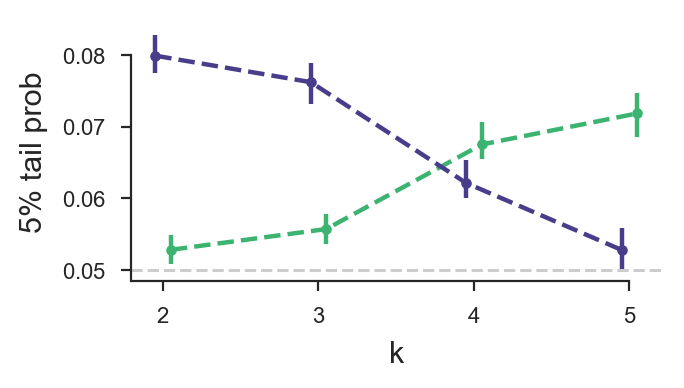

In [541]:
tail_probs_cis_05 = bootstrap_ci(tail_probs[0.05], empnull_tail_probs_bootstraps[0.05])

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_05[:, 1:, :], ax=ax, alpha=0.05)
ax.spines['left'].set_bounds(0.0485, 0.08)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("barghi-tailprobs-0.05.pdf", bbox_inches='tight')

### Barghi Empirical Tail Probabilities for α=0.1

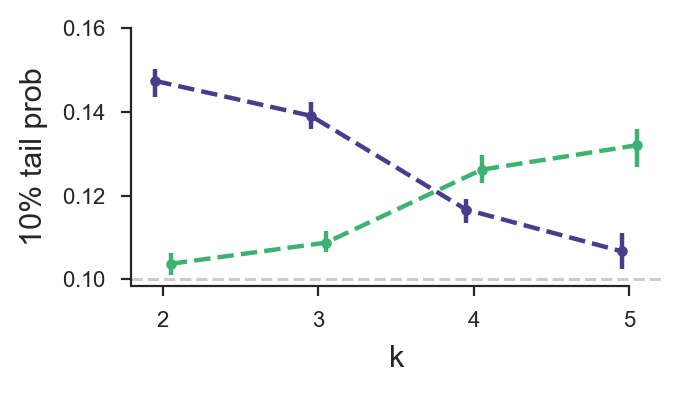

In [542]:
tail_probs_cis_10 = bootstrap_ci(tail_probs[0.10], empnull_tail_probs_bootstraps[0.10])

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_10[:, 1:, :], ax=ax, alpha=0.1)
ax.set_ylim(0.09838, 0.16)
ax.spines['left'].set_bounds(0.09838, 0.16)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("tailprobs-0.10.pdf", bbox_inches='tight')

### Barghi Empirical Tail Probabilities for α=0.2

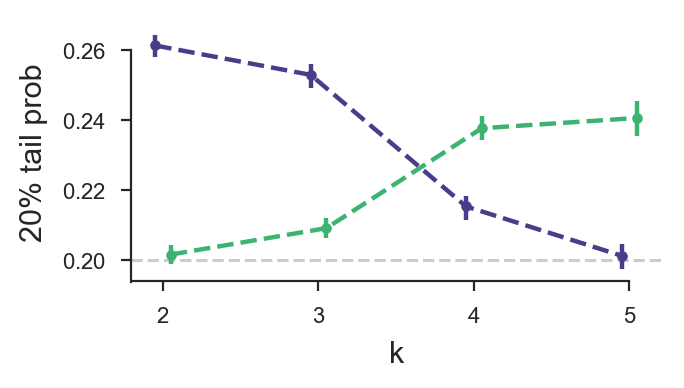

In [543]:
tail_probs_cis_20 = bootstrap_ci(tail_probs[0.20], empnull_tail_probs_bootstraps[0.20])

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_20[:, 1:, :], ax=ax, alpha=0.2)
ax.spines['left'].set_bounds(0.194, 0.26)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("barghi-tailprobs-0.20.pdf", bbox_inches='tight')

In the manuscript, we cite the fold enrichment for α = 0.2; this generates those number:

In [544]:
tail_probs_cis_20[:, 1:, :] / 0.2

array([[[0.99434901, 1.29135963],
        [1.03149488, 1.24924653],
        [1.17088608, 1.06192925],
        [1.17947559, 0.98960217]],

       [[1.00847649, 1.30684901],
        [1.04611212, 1.26491863],
        [1.18874322, 1.07707957],
        [1.2034358 , 1.00678119]],

       [[1.02226492, 1.32392066],
        [1.06012658, 1.28300558],
        [1.20570185, 1.09606691],
        [1.22875226, 1.02625452]]])

### Barghi Empirical Tail Probabilities for α=0.5

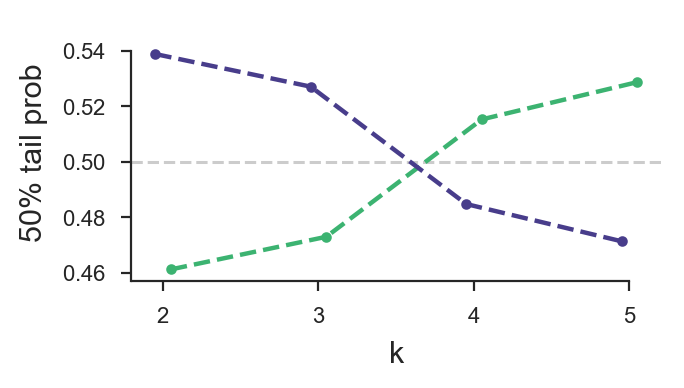

In [545]:
tail_probs_cis_50 = bootstrap_ci(tail_probs[0.5], empnull_tail_probs_bootstraps[0.5])

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_50[:, 1:, :], ax=ax, alpha=0.5)
ax.set_ylim(0.457, 0.55)
ax.spines['left'].set_bounds(0.457, 0.54)
ax.spines['bottom'].set_bounds(1.8, 5)
fig.savefig("barghi-tailprobs-0.50.pdf", bbox_inches='tight')

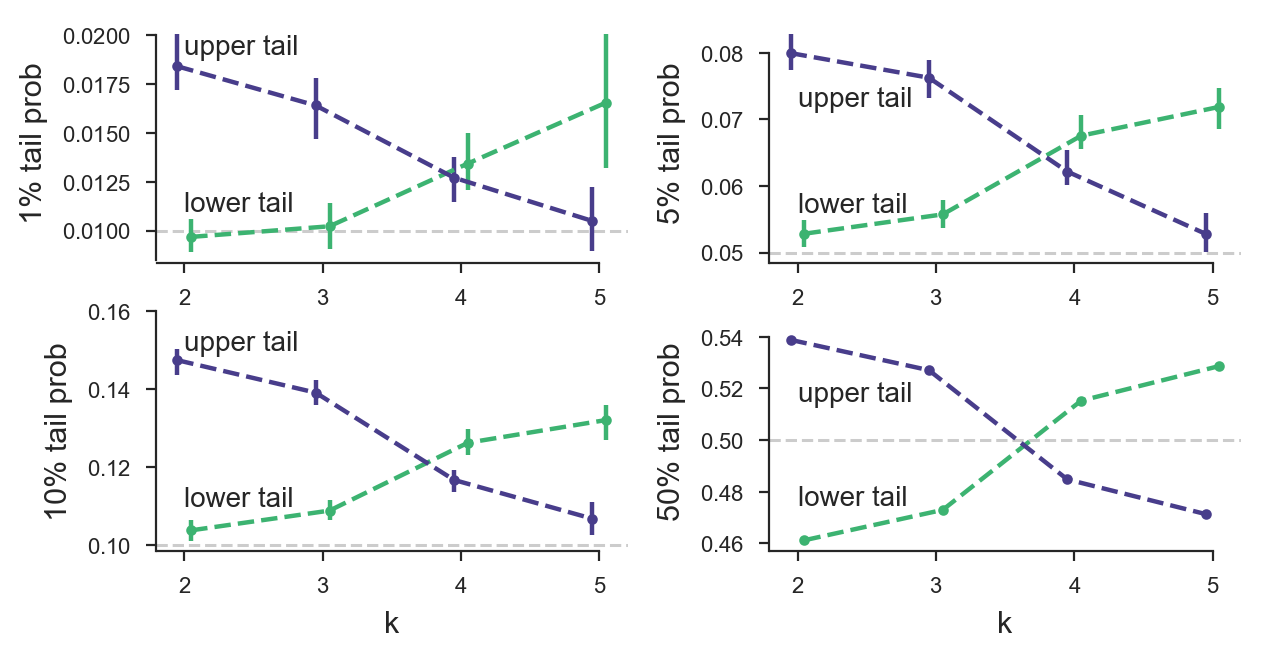

In [525]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(TWOCOL, TWOCOL/2))

plot_tail_probs(tail_probs_cis_01[:, 1:, :], ax=ax[0, 0], alpha=0.01)
ax[0, 0].spines['left'].set_bounds(0.0085, 0.02)
ax[0, 0].spines['bottom'].set_bounds(1.8, 5)
ax[0, 0].text(2, 0.019, "upper tail")
ax[0, 0].text(2, 0.011, "lower tail")
#ax[0, 0].text(3.5, 0.02, f"tail prob = 0.01", horizontalalignment='center')

plot_tail_probs(tail_probs_cis_05[:, 1:, :], ax=ax[0, 1], alpha=0.05)
ax[0, 1].spines['left'].set_bounds(0.0485, 0.08)
ax[0, 1].spines['bottom'].set_bounds(1.8, 5)
ax[0, 1].text(2, 0.072, "upper tail")
ax[0, 1].text(2, 0.056, "lower tail")
#ax[0, 1].text(3.5, 0.08, f"tail prob = 0.05", horizontalalignment='center')

plot_tail_probs(tail_probs_cis_10[:, 1:, :], ax=ax[1, 0], alpha=0.1)
ax[1, 0].set_ylim(0.09838, 0.16)
ax[1, 0].spines['left'].set_bounds(0.09838, 0.16)
ax[1, 0].spines['bottom'].set_bounds(1.8, 5)
ax[1, 0].text(2, 0.15, "upper tail")
ax[1, 0].text(2, 0.11, "lower tail")
#ax[1, 0].text(3.5, 0.16, f"tail prob = 0.10", horizontalalignment='center')

plot_tail_probs(tail_probs_cis_50[:, 1:, :], ax=ax[1, 1], alpha=0.5)
ax[1, 1].set_ylim(0.457, 0.55)
ax[1, 1].spines['left'].set_bounds(0.457, 0.54)
ax[1, 1].spines['bottom'].set_bounds(1.8, 5)
ax[1, 1].text(2, 0.515, "upper tail")
ax[1, 1].text(2, 0.475, "lower tail")
#ax[1, 1].text(3.5, 0.54, f"tail prob = 0.50", horizontalalignment='center')

plt.subplots_adjust(wspace=.3)
fig.savefig("barghi-tailprobs-panels.pdf", bbox_inches='tight')


### More Barhi offset distribution plots

/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """
/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys
/Users/vinceb/miniconda3/envs/basesci/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


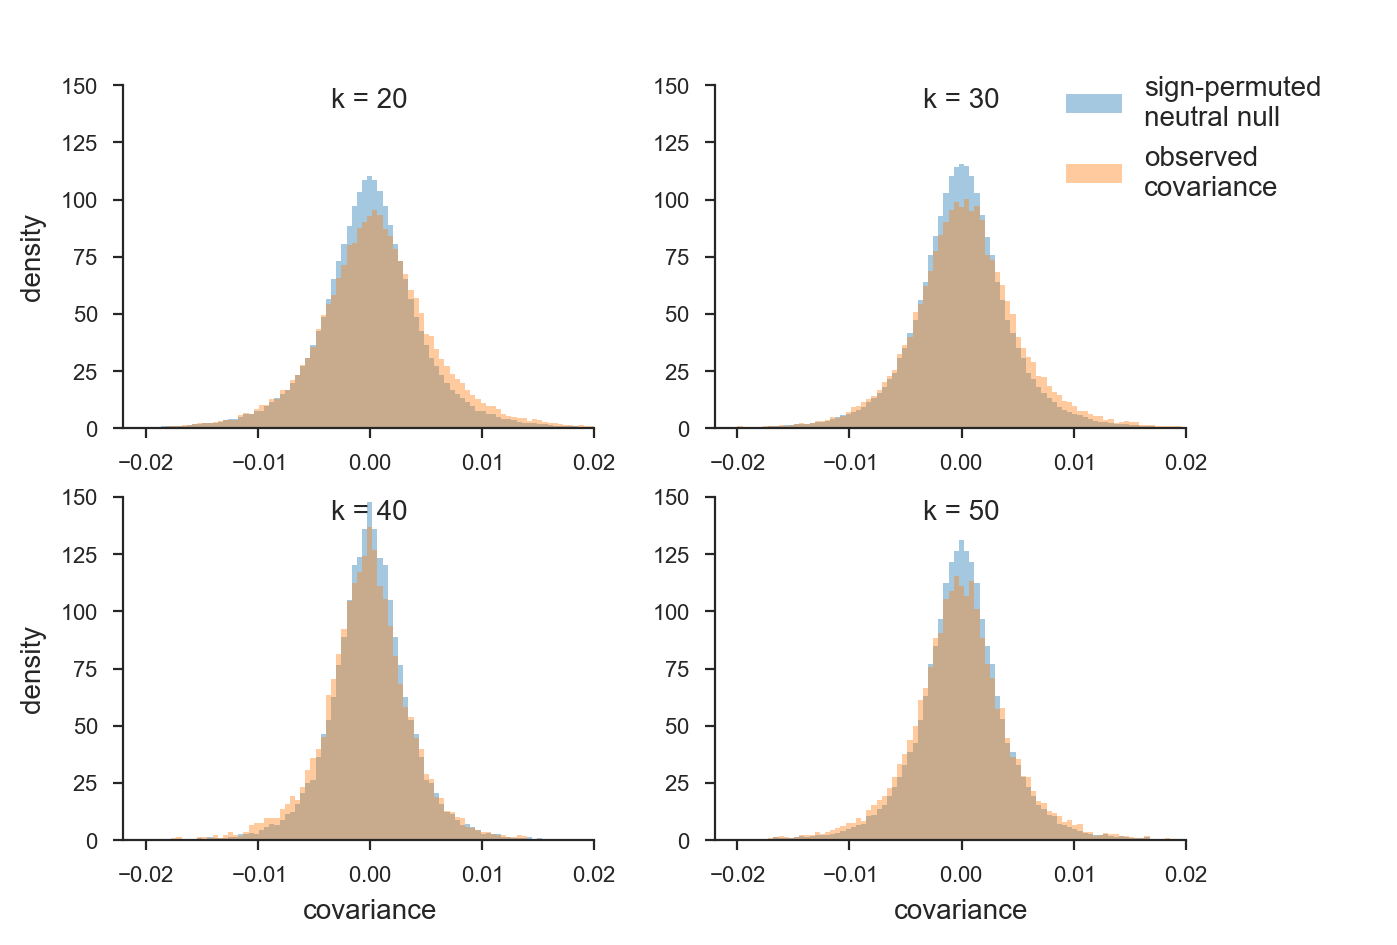

In [316]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(TWOCOL, TWOCOL/1.4))
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=2, rep=None, ax=ax[0, 0], 
         bins=np.linspace(-0.02, 0.02, BEST_NBINS), xlabel='', real_label='observed\ncovariance')
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=3, rep=None, ax=ax[0, 1],
         bins=np.linspace(-0.02, 0.02, BEST_NBINS), xlabel='', ylabel='', real_label='observed\ncovariance')
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=4, rep=None, ax=ax[1, 1], 
         bins=np.linspace(-0.02, 0.02, BEST_NBINS), ylabel='', real_label='observed\ncovariance')
cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=5, rep=None, ax=ax[1, 0], 
         bins=np.linspace(-0.02, 0.02, BEST_NBINS), real_label='observed\ncovariance')
for k, (i, j) in enumerate([(i, j) for i in (0, 1) for j in (0, 1)], 2):
    ax[i, j].set_ylim([0, 150])
    ax[i, j].text(0, 140, f"k = {10*k}", horizontalalignment='center')
    ax[i, j].spines['bottom'].set_bounds(-0.022, 0.02)
    if i == 0 and j == 1:
        ax[i, j].legend(loc=(0.6, 0.5))

plt.savefig('barghi-offset-panels.pdf', bbox_inches="tight")

### Barghi Windowed Covariance Plot for Particular Replicates

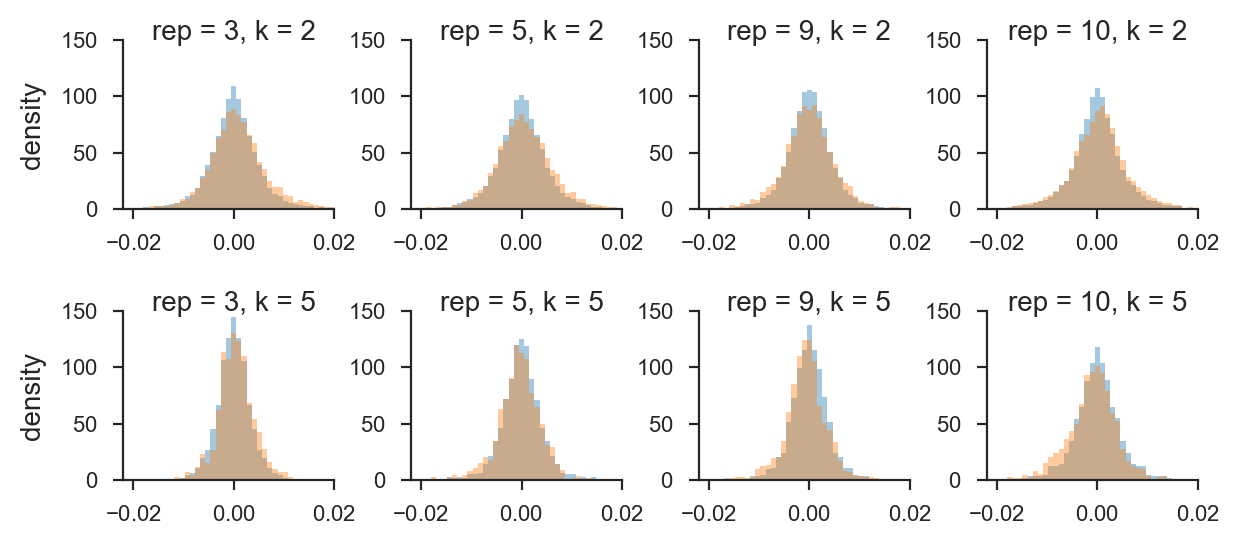

In [318]:
np.random.seed(0)
nreps = 4
fig, ax = plt.subplots(ncols=nreps, nrows=2, figsize=(TWOCOL, TWOCOL/2.4))

reps = sorted(np.random.choice(np.arange(10), replace=False, size=nreps))
ks = [2, 5]

for i in range(nreps):
    for j in (0, 1):
        ylabel = '' if i > 0 else 'density'
        cov_hist(barghi_emp_null_tile, barghi_tile_covs, k=ks[j], ax=ax[j, i], rep=reps[i], 
             bins=np.linspace(-0.02, 0.02, 40), xlabel='', ylabel=ylabel, real_label='observed\ncovariance')
        ymax = 150 
        ax[j, i].set_ylim(0, ymax)
        ax[j, i].spines['left'].set_bounds(0, ymax)
        ax[j, i].spines['bottom'].set_bounds(-0.022, 0.02)
        ax[j, i].text(0, ymax, f'rep = {reps[i]+1}, k = {ks[j]}', horizontalalignment='center')

plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.savefig('barghi-offset-replicate-panels.pdf', bbox_inches="tight")

## Chromosome-level sign permutation

In [476]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.5]

empnull_tail_probs_bootstraps_seqid = dict()
for alpha in alphas:
    FILENAME = f'../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_{alpha}_seqid.npy'
    if not os.path.exists(FILENAME):
        print(f"bootstrapping for {FILENAME}")
        empnull_tail_probs_bootstraps_seqid[alpha] = np.array(bootstrap_tail_probs(barghi_emp_null_seqid, barghi_tile_covs,
                                                                                   B=1000, alpha=alpha, progress_bar=True))
        with open(FILENAME, 'wb') as f:
            np.save(f, empnull_tail_probs_bootstraps_seqid[alpha])
    else:
         with open(FILENAME, 'rb') as f:
            print(f"loading bootstraps for {FILENAME}")
            empnull_tail_probs_bootstraps_seqid[alpha] = np.load(f)

loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.01_seqid.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.05_seqid.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.1_seqid.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.2_seqid.npy
loading bootstraps for ../../data/barghi_et_al_2019/empnull_tail_probs_bootstraps_alpha_0.5_seqid.npy


In [477]:
T = 6

# estimate the tail probabilities for each k
tail_probs_seqid = dict()
for alpha in alphas:
    probs = []
    for k in np.arange(1, T):
        emp_null_covs = np.diagonal(barghi_emp_null_seqid, k, 2, 3)
        obs_covs = np.diagonal(barghi_tile_covs, k, 1, 2)
        probs.append(calc_tail_probs(emp_null_covs, obs_covs, alpha=alpha))
    tail_probs_seqid[alpha] = np.array(probs)

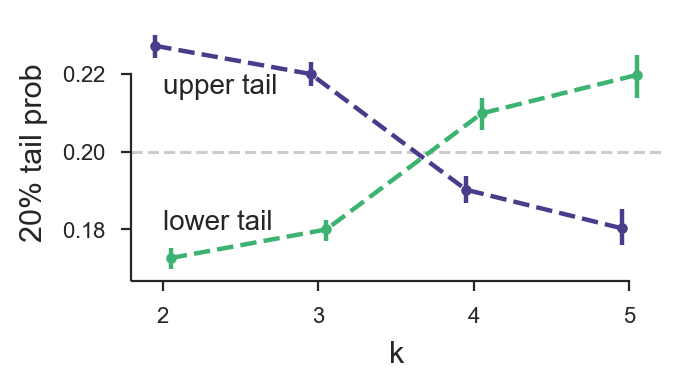

In [529]:
tail_probs_cis_20_seqid = bootstrap_ci(tail_probs_seqid[0.2], empnull_tail_probs_bootstraps_seqid[0.2])

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL/2))
plot_tail_probs(tail_probs_cis_20_seqid[:, 1:, :], ax=ax, alpha=0.2)
ax.spines['left'].set_bounds(0.167, 0.22)
ax.spines['bottom'].set_bounds(1.8, 5)
ax.text(2, 0.215, "upper tail")
ax.text(2, 0.18, "lower tail")
fig.savefig("barghi-tailprobs-seqid-20.pdf")

### Barghi Trimmed Mean

In [8]:
with open(f'../../data/barghi_et_al_2019/tile_temporal_covs_1e5.npy', 'rb') as f:
    tile_temp_covs = np.load(f)

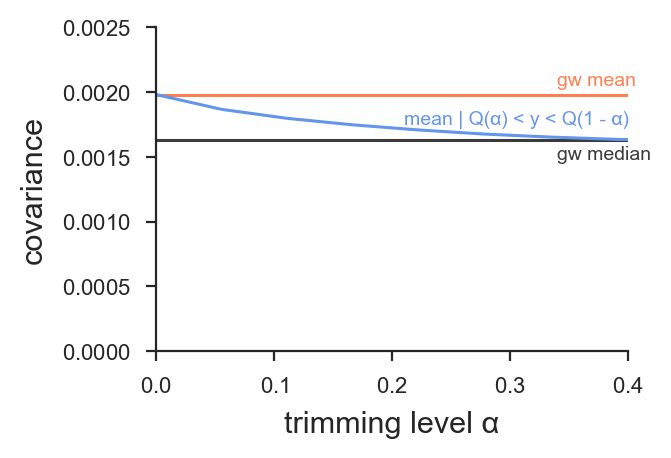

In [77]:
t=1
y = tile_temp_covs[:, 0, t, :].ravel()
y.sort()

alphas = np.linspace(0, 0.5, 10)

lower = np.quantile(y, alphas)
upper = np.quantile(y, 1-alphas)

res = np.array([(a, np.mean(y[(y > l) & (y < u)])) for a, l, u in zip(alphas, lower, upper)])

fig, ax = plt.subplots(figsize=(ONECOL, ONECOL*.7))
ax.axhline(np.mean(tile_temp_covs[:, 0, t, :]), c='coral')
ax.axhline(np.median(tile_temp_covs[:, 0, t, :]), c='0.23')
ax.plot(res[:, 0], res[:, 1], color='cornflowerblue')
ax.set_ylim(0, 0.0025)
ax.set_ylabel('covariance')
ax.set_xlabel('trimming level α')
ax.text(0.34, 0.00205, 'gw mean', color='coral', fontsize=7)
ax.text(0.34, 0.00148, 'gw median', color='0.23', fontsize=7)
ax.text(0.21, 0.00175, 'mean | Q(α) < y < Q(1 - α) ', color='cornflowerblue', fontsize=7)
ax.set_xlim(0, 0.4)
plt.tight_layout()
fig.savefig("barghi-trimmed-mean.pdf")

In [80]:
for t in range(1, 6):
    print(f"t = {t}", np.median(tile_temp_covs[:, 0, t, :]))

t = 1 0.0016290084977915096
t = 2 0.00037106998767996637
t = 3 0.0004789778797822972
t = 4 5.91264985556747e-05
t = 5 -0.00020419679325531557


## Median estimates

In [170]:
B = 2000

def format_ci(vals, mult=1, digits=1):
    l, e, u = vals
    return f"$[{(l*mult).round(digits)}, {(u*mult).round(digits)}]$"

sigfig = 1
mult = 1000
print("s & t & median & median 95\% CI & trimmed mean & trimmed mean 95\% CI  \\\\ \hline")
for refgen in range(0, 6):
    for t in range(refgen+1, 6):
        y = tile_temp_covs[:, refgen, t, :].ravel()
        medians, means = [], []
        for b in np.arange(B):
            idx = np.random.randint(0, len(y), len(y))
            yrs = y[idx]  # resampled
            medians.append(np.median(yrs))
            
            l, u = np.quantile(yrs, (0.05, 0.95))
            tm = np.nanmean(yrs[(yrs > l) & (yrs < u)])
            means.append(tm)
            
        # estimates 
        l, u = np.quantile(y, (0.05, 0.95))
        trimmed_mean = np.nanmean(y[(y > l) & (y < u)])
        median = np.median(y)
 
        #print(f"refgen = {refgen}, t={t}", bootstrap_ci(np.median(y), np.array(medians)))
        
        median_bs = bootstrap_ci(median, np.array(medians))
        trimmed_bs = bootstrap_ci(trimmed_mean, np.array(means))
        print(f"{refgen*10} & {t*10} & {(mult * median).round(3)} & {format_ci(median_bs, mult, digits=3)} " + 
              f"& {(mult * trimmed_mean).round(3)}"+
              f" & {format_ci(trimmed_bs, mult, digits=3)} \\\\")
        

s & t & median & median 95\% CI & trimmed mean & trimmed mean 95\% CI  \\ \hline
0 & 10 & 1.629 & $[1.529, 1.742]$ & 1.874 & $[1.772, 1.979]$ \\
0 & 20 & 0.371 & $[0.279, 0.467]$ & 0.491 & $[0.396, 0.587]$ \\
0 & 30 & 0.479 & $[0.392, 0.588]$ & 0.516 & $[0.429, 0.599]$ \\
0 & 40 & 0.059 & $[-0.014, 0.154]$ & 0.027 & $[-0.047, 0.101]$ \\
0 & 50 & -0.204 & $[-0.267, -0.132]$ & -0.259 & $[-0.329, -0.19]$ \\
10 & 20 & 1.549 & $[1.424, 1.659]$ & 1.722 & $[1.62, 1.825]$ \\
10 & 30 & 0.438 & $[0.339, 0.539]$ & 0.506 & $[0.399, 0.604]$ \\
10 & 40 & 0.233 & $[0.15, 0.332]$ & 0.254 & $[0.167, 0.354]$ \\
10 & 50 & -0.355 & $[-0.441, -0.29]$ & -0.319 & $[-0.403, -0.236]$ \\
20 & 30 & 1.981 & $[1.844, 2.096]$ & 2.195 & $[2.082, 2.301]$ \\
20 & 40 & 0.792 & $[0.698, 0.884]$ & 0.903 & $[0.813, 0.992]$ \\
20 & 50 & 0.123 & $[0.038, 0.217]$ & 0.221 & $[0.138, 0.307]$ \\
30 & 40 & 1.296 & $[1.198, 1.426]$ & 1.385 & $[1.284, 1.488]$ \\
30 & 50 & 0.07 & $[-0.039, 0.184]$ & 0.116 & $[0.021, 0.212]$ \\
40 &

## Bergland et al (2014) Covariance Plots

In [831]:
with open(f'../../data/bergland_et_al_2014/tile_temporal_covs_1e6.npy', 'rb') as f:
    gw_temp_covs_cis = np.load(f)

In [859]:
def sample_name(x):
    _, month, year = x.split('_')
    return month + "/" + year[2:]

samples = [sample_name(x) for x in 
           ['PA_7_2009',
           'PA_11_2009',
           'PA_7_2010',
           'PA_11_2010',
           'PA_7_2011',
           'PA_10_2011']]

#np.meshgrid(samples, samples)
sample_diffs = [i + '-' + j for i, j in zip(samples[1:], samples[:-1])]
cols, rows = np.meshgrid(sample_diffs, sample_diffs)
x = np.empty_like(rows, dtype='U60')

for i in range(rows.shape[0]):
    for j in range(rows.shape[1]):
        label = f"cov({rows[i, j]}, {cols[i, j]})" 
        x[i, j] = label
np.set_printoptions(linewidth=1000)
def format_season_ticks(x):
    m, y = x.split('/')
    return {'7':'Spring'}.get(m, 'Fall') + ' ' + y
seasonal_xticks = [format_season_ticks(x.split('-')[1]) for x in cols[0,1:]]
print(x)
print("\nticks: ", xticks)  # ignore variance, and get last timepoint 

[['cov(11/09-7/09, 11/09-7/09)' 'cov(11/09-7/09, 7/10-11/09)' 'cov(11/09-7/09, 11/10-7/10)' 'cov(11/09-7/09, 7/11-11/10)' 'cov(11/09-7/09, 10/11-7/11)']
 ['cov(7/10-11/09, 11/09-7/09)' 'cov(7/10-11/09, 7/10-11/09)' 'cov(7/10-11/09, 11/10-7/10)' 'cov(7/10-11/09, 7/11-11/10)' 'cov(7/10-11/09, 10/11-7/11)']
 ['cov(11/10-7/10, 11/09-7/09)' 'cov(11/10-7/10, 7/10-11/09)' 'cov(11/10-7/10, 11/10-7/10)' 'cov(11/10-7/10, 7/11-11/10)' 'cov(11/10-7/10, 10/11-7/11)']
 ['cov(7/11-11/10, 11/09-7/09)' 'cov(7/11-11/10, 7/10-11/09)' 'cov(7/11-11/10, 11/10-7/10)' 'cov(7/11-11/10, 7/11-11/10)' 'cov(7/11-11/10, 10/11-7/11)']
 ['cov(10/11-7/11, 11/09-7/09)' 'cov(10/11-7/11, 7/10-11/09)' 'cov(10/11-7/11, 11/10-7/10)' 'cov(10/11-7/11, 7/11-11/10)' 'cov(10/11-7/11, 10/11-7/11)']]

ticks:  ['Fall 09', 'Spring 10', 'Fall 10', 'Spring 11']


In [860]:
# this plot code is a bit hellish...

def cov_plot2(cov_cis, labels=None, offsets=None, ax=None, alpha=1, error_alpha=1, ngens=1, linewidth=1, ylim=None, xlim=None, hline=True, 
             cmap=cm.Dark2, y_multiplier=None, xticks=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    _, T, T = cov_cis.shape
    y_multiplier = y_multiplier if y_multiplier is not None else 1
    for refgen in range(T):
        x = np.arange(refgen, T)
        mean = y_multiplier*cov_cis[1][refgen, (refgen+1):]
        lower, upper = y_multiplier*cov_cis[0][refgen, (refgen+1):]-mean, mean-y_multiplier*cov_cis[2][refgen, (refgen+1):]
        
        ax.plot(x[:-1], mean, '-o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
                label=refgen, zorder=refgen, markersize=2.5) #markersize=3.5)#, markeredgecolor='w')
        if labels is not None:
            for i, xx in enumerate(x[:-1]):
                ax.text(xx, mean[i] + offsets[refgen, i], labels[refgen, i+1], fontsize=5, horizontalalignment='left')
        ax.errorbar(x[:-1], mean, yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
                    capsize=0, elinewidth=linewidth, c=cmap(refgen), 
                    linewidth=0,
                    zorder=100+refgen, alpha=error_alpha, label=None, solid_capstyle='round')

    if ylim is not None:
        ax.set_ylim(ylim)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    #plt.xticks(np.arange(0, T*ngens, 10))
    if xticks is not None:
        ax.set_xticks(np.arange(4))
        ax.set_xticklabels(xticks)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1e6, linestyle='--')
    
    if ylab is None:
        ylab = "covariance"
        if y_multiplier is not None:
            ylab += f"  $(\\times 10^{{{int(np.log10(1/y_multiplier))}}})$"
        

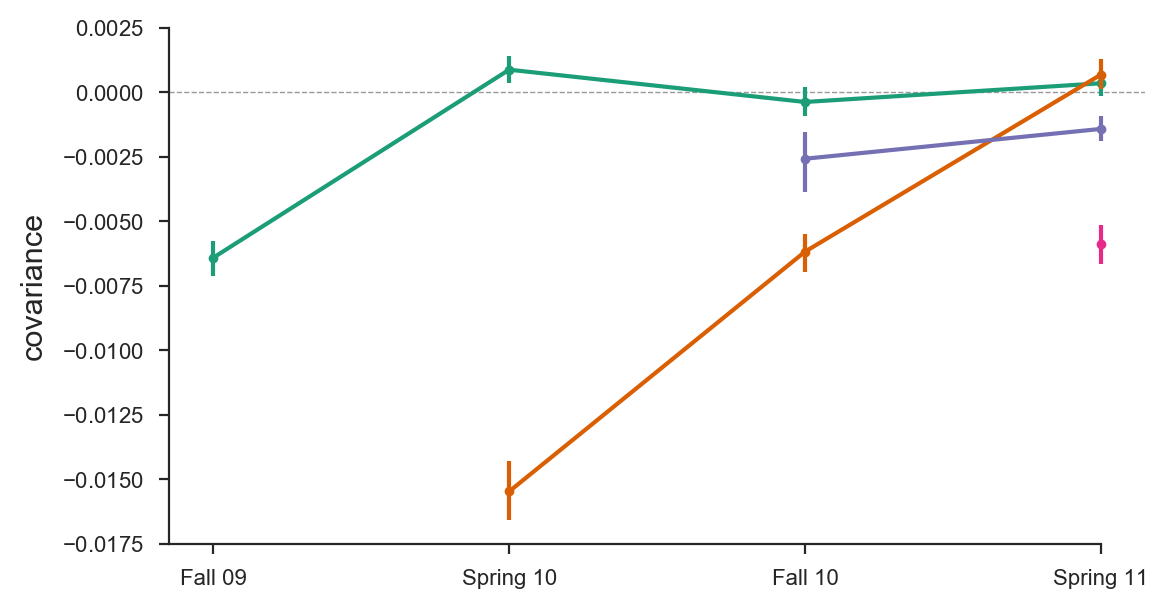

In [862]:
offsets = np.array([[0, -0.015, 0.01, 0.01, 0.01],
                    [0,  0,  -0.02, -0.01, -0.01],
                    [0,  0,     0, -0.02, -0.05],
                    [0,  0,     0,     0, -0.02]])/10

fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(TWOCOL*0.9, ONECOL))
cov_plot2(gw_temp_covs_cis, ax=ax, ngens=1, ylim=(-0.0175, 0.0025), 
          linewidth=1.5, xticks=seasonal_xticks)
ax.spines['bottom'].set_bounds(ax.get_xlim()[0], 3)
ax.set_ylabel("covariance")
plt.savefig('bergland-covs.pdf', bbox_inches="tight")

## Bergland et al (2014) Re-Analysis Plots

In [351]:
pvalue_comparison = pd.read_csv('../../data/bergland_et_al_2014/bergland_pvalue_comparison.csv')

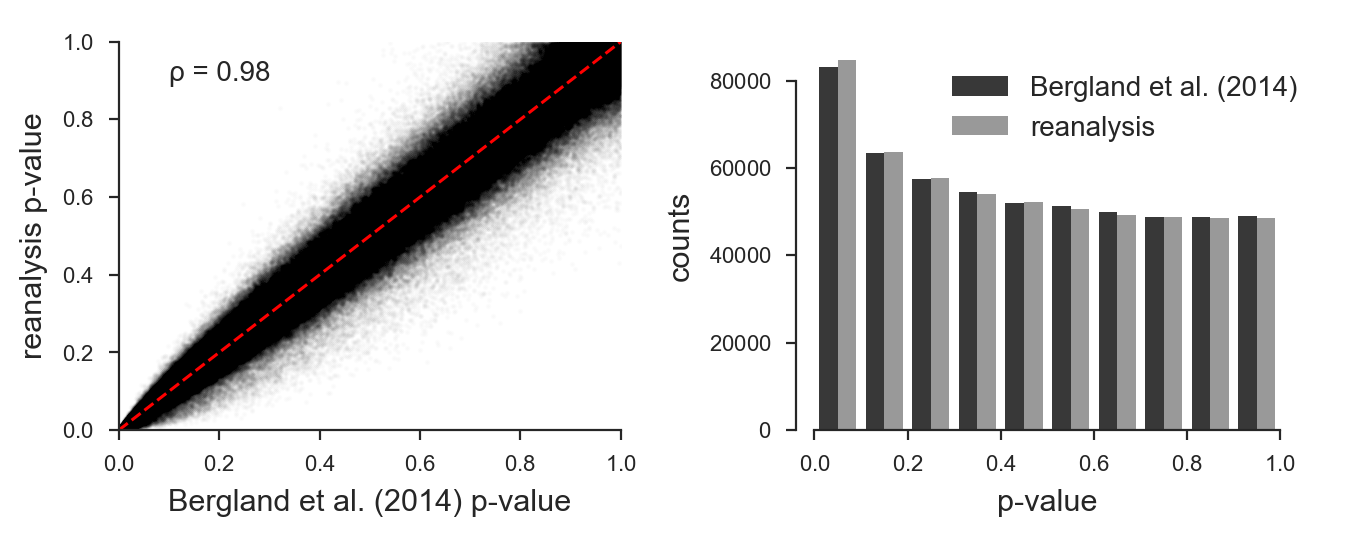

In [537]:
def abline(ax, slope=1, intercept=0, **kwargs):
    x = np.array(ax.get_xlim())
    y = intercept + slope * x
    ax.plot(x, y, '--', **kwargs)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(TWOCOL, ONECOL*0.8))
bergland_pvals, our_pvals = pvalue_comparison['bergland_pvals'].values, pvalue_comparison['our_pvals'].values
ax[0].scatter(bergland_pvals, our_pvals, alpha=0.01, s=1, c='k')
#ax.hist2d(-np.log10(SP+1), -np.log10(pvals+1), 30)
ax[0].text(0.1, 0.9, f"ρ = {np.corrcoef(bergland_pvals, our_pvals)[0, 1].round(2)}")
r = np.corrcoef(bergland_pvals, our_pvals)
n = our_pvals.size
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[0].spines['left'].set_bounds(ax[0].get_ylim()[0], 1)
ax[0].spines['bottom'].set_bounds(ax[0].get_xlim()[0], 1)
ax[0].set_ylabel("reanalysis p-value")
ax[0].set_xlabel("Bergland et al. (2014) p-value")
abline(ax[0], c='r')

ax[1].hist(np.stack((bergland_pvals, our_pvals)).T, 10,
           label=("Bergland et al. (2014)", "reanalysis"), 
           color=(str(56/255), str(153/255)))
ax[1].spines['left'].set_bounds(ax[0].get_ylim()[0], 80000)
ax[1].spines['bottom'].set_bounds(ax[0].get_xlim()[0], 1)
ax[1].set_ylabel("counts")
ax[1].set_xlabel("p-value")
ax[1].legend(loc=(0.2, 0.6))
plt.tight_layout()
plt.savefig('bergland-pvalue-comparison.png', bbox_inches="tight")

In [395]:
with open('../../data/bergland_et_al_2014/locus_level_permutation_pvalues.npy', 'rb') as f:
    locus_permuted_pvals = np.load(f)

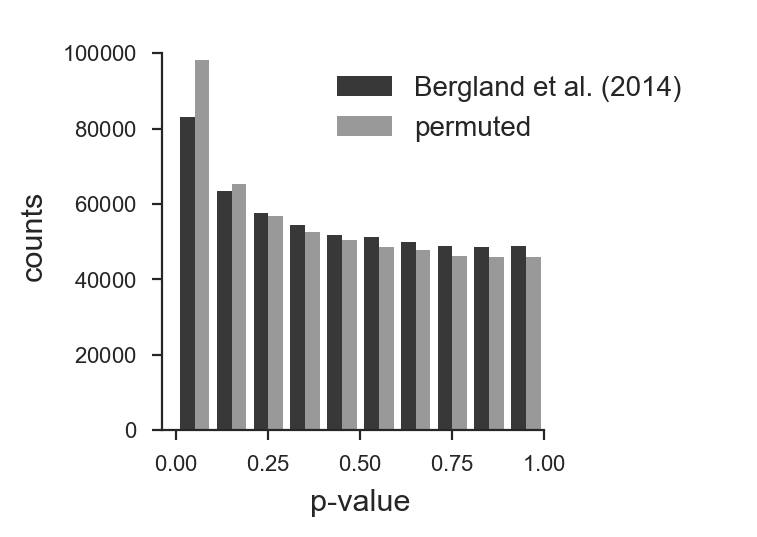

In [913]:
NREPS = locus_permuted_pvals.shape[0]
labels = tuple(['seasonal'] + [f'permuted-{r+1}' for r in range(NREPS)])
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(ONECOL, ONECOL*0.8))
h = ax.hist(np.hstack((bergland_pvals.reshape(-1, 1), locus_permuted_pvals[0, :, np.newaxis])), 10, 
        label=('Bergland et al. (2014)', 'permuted'),
        color=[str(56/255), str(153/255)])
ax.legend(loc=(0.3, 0.6))
ax.spines['left'].set_bounds(ax.get_ylim()[0], 100000)
ax.spines['bottom'].set_bounds(ax.get_xlim()[0], 1)
ax.set_ylabel('counts')
ax.set_xlabel('p-value')

# rep_ys = [np.histogram(locus_permuted_pvals[i, :], 10)[0] for i in range(NREPS)]
# min = np.array(rep_ys).min(axis=0)
# max = np.array(rep_ys).max(axis=0)
# ax.vlines(np.linspace(0, 1, 10), ymin=min, ymax=max)
plt.tight_layout()
plt.savefig('bergland-pvalue-permutation-hist.pdf', bbox_inches="tight")


In [865]:
with open('../../data/bergland_et_al_2014/rep_level_permutation_pvalues.npy', 'rb') as f:
    rep_permuted_pvals = np.load(f)

The permtuations are:

```
[(0, 0, 0, 1, 1, 1),
 (0, 0, 1, 0, 1, 1),
 (0, 0, 1, 1, 0, 1),
 (0, 0, 1, 1, 1, 0),
 (0, 1, 0, 0, 1, 1),
 (0, 1, 0, 1, 0, 1),
 (0, 1, 0, 1, 1, 0),
 (0, 1, 1, 0, 0, 1),
 (0, 1, 1, 0, 1, 0),
 (0, 1, 1, 1, 0, 0)]
 ```
 
 So we delete the 5th one (0 indexed) which is the seaonal one.

In [879]:
rep_pvals = np.delete(rep_permuted_pvals, 5, axis=0)

Since all permutations have equal weighting (see Bergland reanalysis notebook), we pool all p-values (unweighted).

In [890]:
np.histogram(rep_pvals, 10)

(array([897573, 586144, 513855, 474675, 451580, 435693, 424296, 416326, 411378, 410363]),
 array([1.58781905e-11, 9.99999841e-02, 1.99999968e-01, 2.99999952e-01, 3.99999936e-01, 4.99999920e-01, 5.99999905e-01, 6.99999889e-01, 7.99999873e-01, 8.99999857e-01, 9.99999841e-01]))

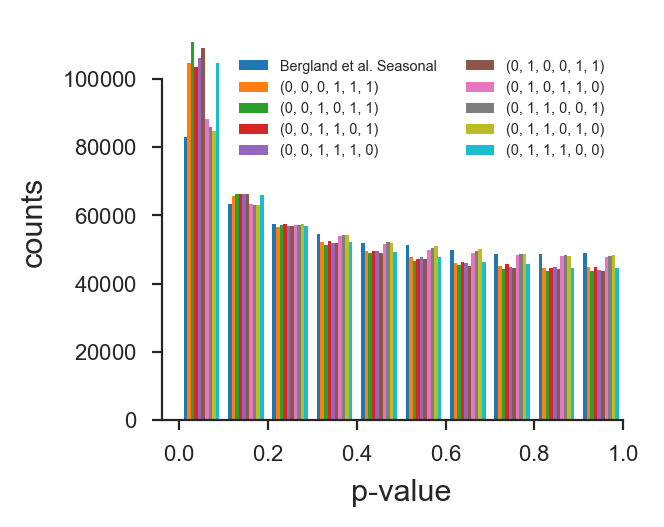

In [926]:
NREPS = locus_permuted_pvals.shape[0]
labels = tuple(['seasonal'] + [f'permuted-{r+1}' for r in range(NREPS)])
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(ONECOL, ONECOL*0.8))
labs = [
 'Bergland et al. Seasonal',
 (0, 0, 0, 1, 1, 1),
 (0, 0, 1, 0, 1, 1),
 (0, 0, 1, 1, 0, 1),
 (0, 0, 1, 1, 1, 0),
 (0, 1, 0, 0, 1, 1),
 (0, 1, 0, 1, 1, 0),
 (0, 1, 1, 0, 0, 1),
 (0, 1, 1, 0, 1, 0),
 (0, 1, 1, 1, 0, 0)]
h = ax.hist(np.hstack((bergland_pvals.reshape(-1, 1), rep_pvals.T)), 10,
        label=labs)
        #color=[str(56/255), str(153/255)])
ax.legend(loc=0, ncol=2, prop={'size': 5.2})
ax.spines['left'].set_bounds(ax.get_ylim()[0], 100000)
ax.spines['bottom'].set_bounds(ax.get_xlim()[0], 1)
ax.set_ylabel('counts')
ax.set_xlabel('p-value')

# rep_ys = [np.histogram(locus_permuted_pvals[i, :], 10)[0] for i in range(NREPS)]
# min = np.array(rep_ys).min(axis=0)
# max = np.array(rep_ys).max(axis=0)
# ax.vlines(np.linspace(0, 1, 10), ymin=min, ymax=max)
plt.tight_layout()
plt.savefig('bergland-pvalue-rep-permutation-hist.pdf', bbox_inches="tight")


## Barghi et al (2019) Correction Plots

In [558]:
with open('../../data/barghi_et_al_2019/diagonistics_tuple.pkl', 'rb') as f:
    barghi_diagonistics = pickle.load(f)

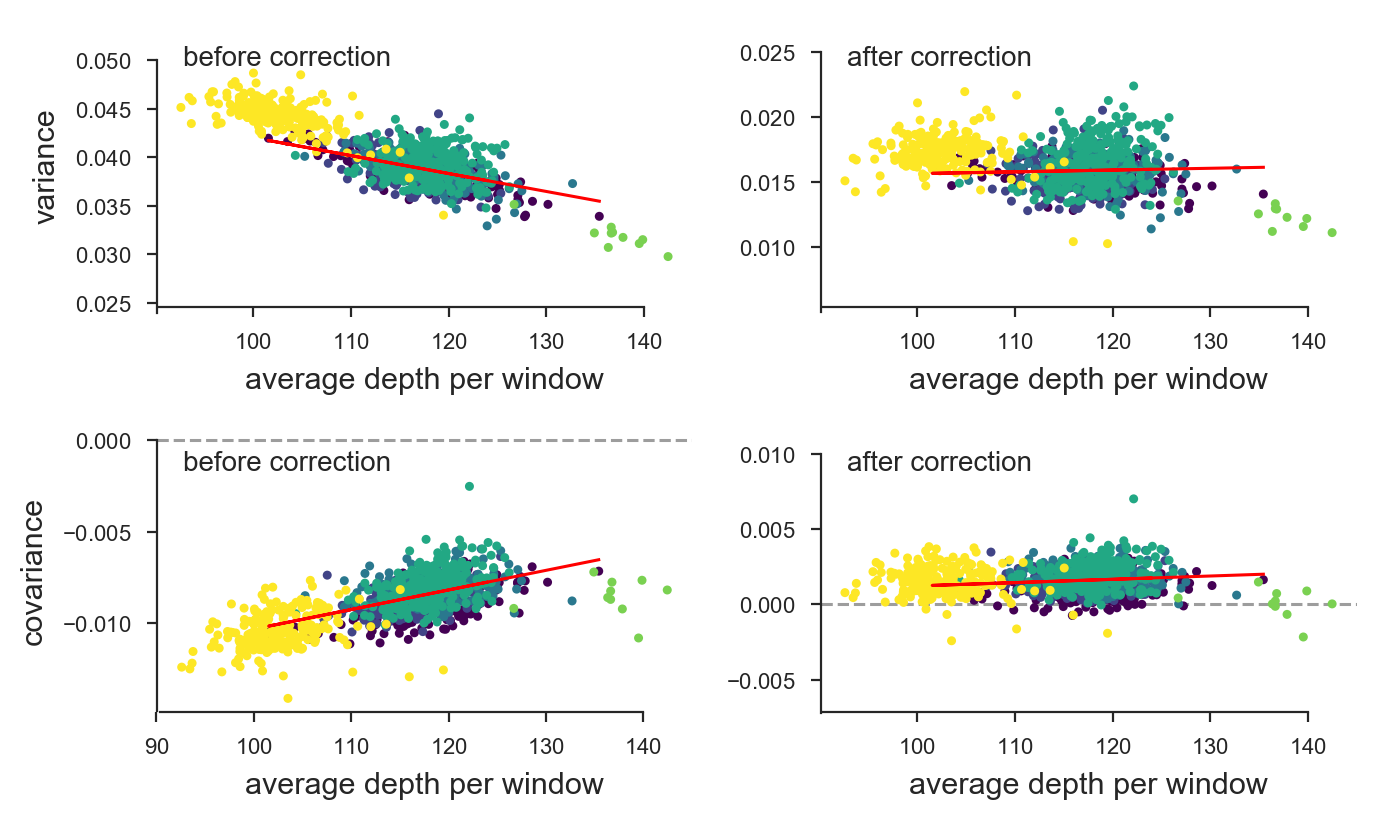

In [559]:
plt.rc('text', usetex=False)
fig, ax = correction_diagnostic_plot(barghi_diagonistics, figsize=(TWOCOL, TWOCOL*0.6))

ax[0, 0].spines['left'].set_bounds(0.024, 0.05)
ax[0, 0].spines['bottom'].set_bounds(90.4, 140)

ax[0, 1].spines['left'].set_bounds(0.005, 0.025)
ax[0, 1].spines['bottom'].set_bounds(90.4, 140)

ax[1, 0].spines['left'].set_bounds(-0.0148, 0.0)
ax[1, 0].spines['bottom'].set_bounds(90.4, 140)


ax[1, 1].spines['left'].set_bounds(-0.0072, 0.01)
ax[1, 1].spines['bottom'].set_bounds(90.4, 140)

plt.savefig('barghi-correction-plot.pdf', bbox_inches="tight")

## Bergland et al (2014) Correction Plots

In [560]:
with open('../../data/bergland_et_al_2014/bergland_diagonistics_tuple.pkl', 'rb') as f:
    bergland_diagonistics = pickle.load(f)

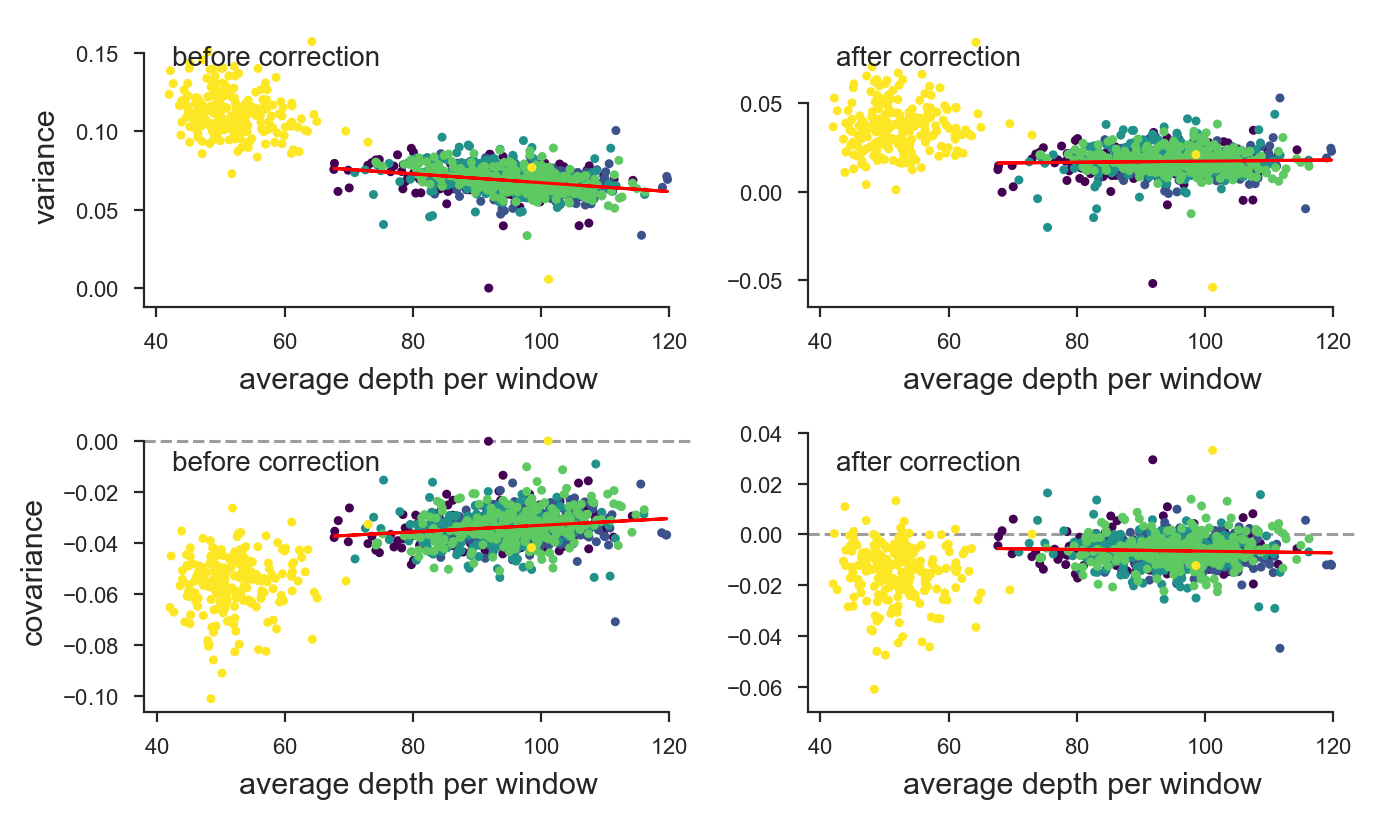

In [561]:
plt.rc('text', usetex=False)
fig, ax = correction_diagnostic_plot(bergland_diagonistics, figsize=(TWOCOL, TWOCOL*0.6))

ax[0, 0].spines['left'].set_bounds(ax[0, 0].get_ylim()[0], 0.15)
ax[0, 0].spines['bottom'].set_bounds(ax[0, 0].get_xlim()[0], 120)

ax[0, 1].spines['left'].set_bounds(ax[0, 1].get_ylim()[0], 0.05)
ax[0, 1].spines['bottom'].set_bounds(ax[0, 1].get_xlim()[0], 120)

ax[1, 0].spines['left'].set_bounds(ax[1, 0].get_ylim()[0], 0.0)
ax[1, 0].spines['bottom'].set_bounds(ax[1, 0].get_xlim()[0], 120)

ax[1, 1].spines['left'].set_bounds(ax[1, 1].get_ylim()[0], 0.04)
ax[1, 1].spines['bottom'].set_bounds(ax[1, 1].get_xlim()[0], 120)

plt.savefig('bergland-correction-plot.pdf', bbox_inches="tight")

## Multipanel per-replicate Barghi et al Temporal Covariance plots

In [930]:
with open('../../data/barghi_et_al_2019/gw_covs_cis.npy', 'rb') as f:
    barghi_gw_covs_cis = np.load(f)

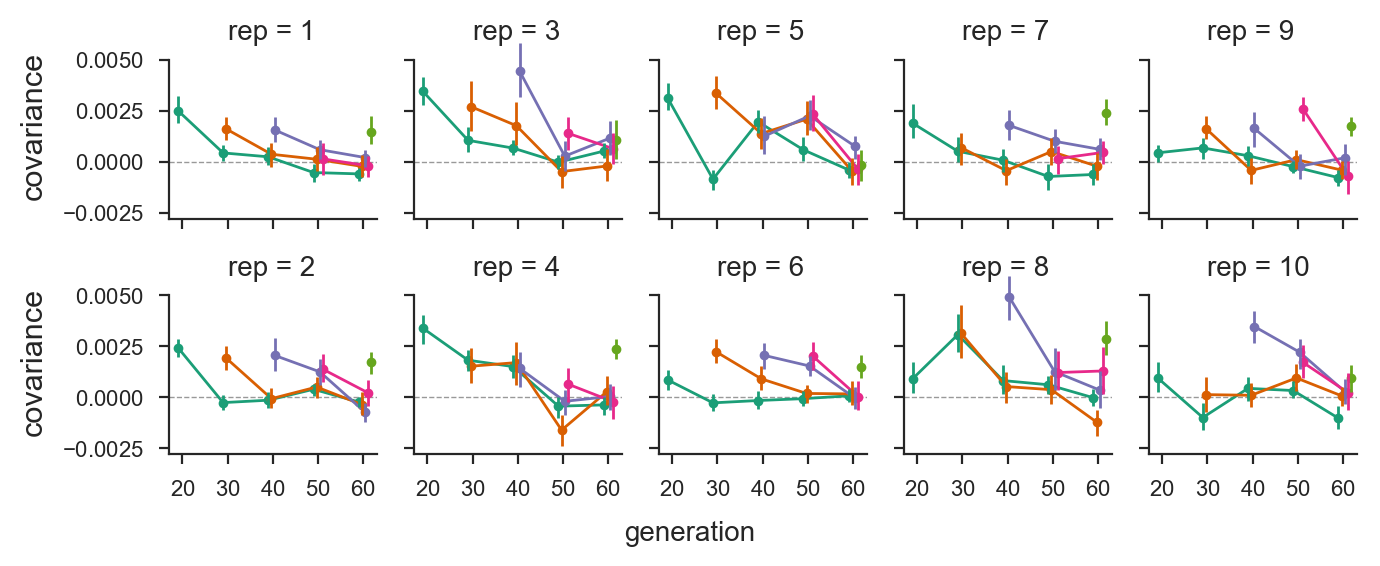

In [1007]:
barghi_temp_allcovs_cis = np.array([stack_temporal_covariances(barghi_gw_covs_cis[i,...], 10, 6) for i in np.arange(3)])

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(TWOCOL, THREEHALVESCOL*0.6), sharey=True, sharex=True)

_, T, T_, R = barghi_temp_allcovs_cis.shape

rep = 0
for i in range(5):
    for j in range(2):
        ylab = ''
        if i == 0:
            ylab = 'covariance'
        xlab = ''
        cov_plot(barghi_temp_allcovs_cis[:, :, :, rep], ax=ax[j, i], ngens=10, ylab=ylab, xticks=np.arange(0, 63, 10))
        ax[j, i].text(30, 0.006, f"rep = {rep+1}")
        ax[j, i].spines['left'].set_bounds(-0.0028, 0.005)
        #ax[j, i].spines['bottom'].set_bounds(ax[j, i].get_xlim()[0], 60)
        ax[j, i].set_xlim(17, 63)
        rep += 1

fig.text(0.5, -0.02, 'generation', ha='center')
plt.tight_layout()

plt.savefig('barghi-cov-panels.pdf', bbox_inches="tight")

## Barghi PCA plot

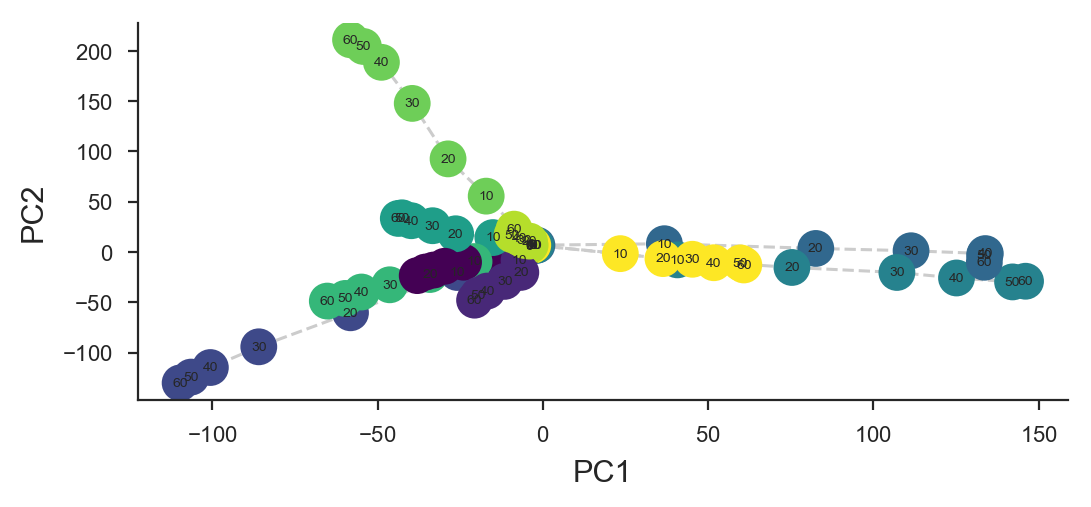

In [42]:
from cvtk.plots import rep_plot_pca2
pc_df = pd.read_csv('../../data/barghi_et_al_2019/pca_df.csv')

fig, ax = rep_plot_pca2(pc_df, 1, 2, s=150, fontsize=5)

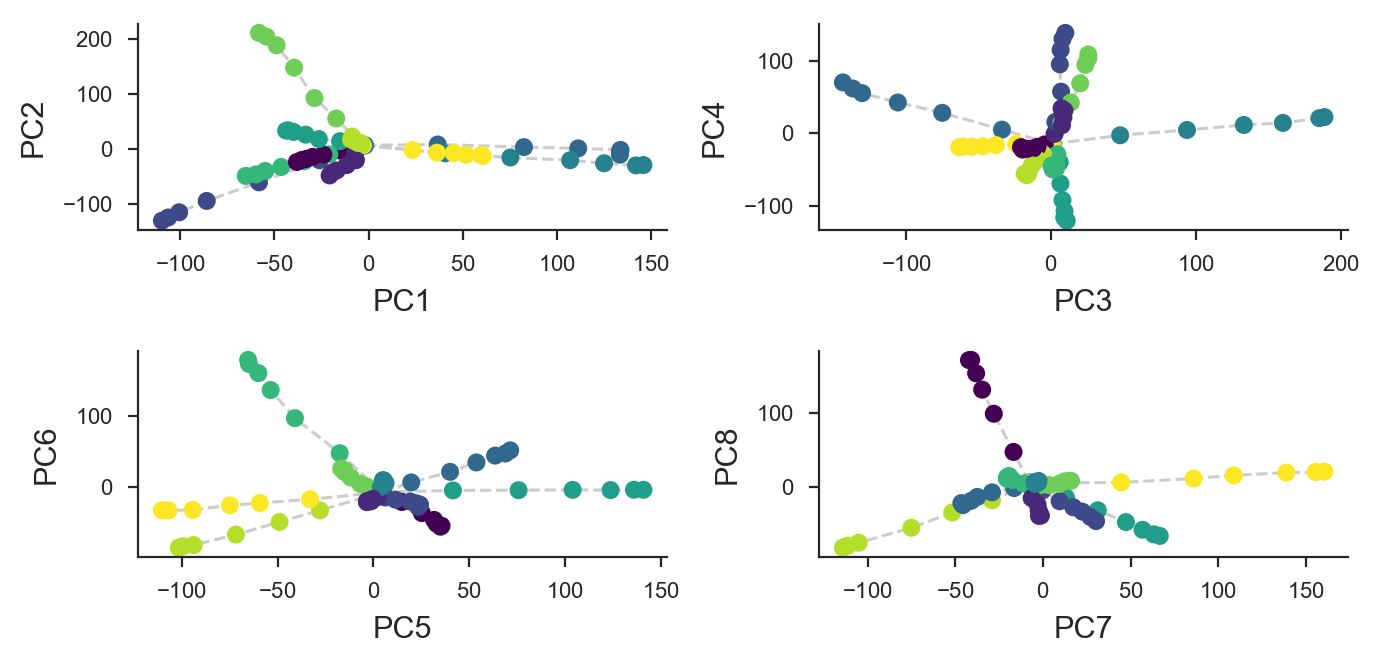

In [52]:
f = plt.figure(figsize=(TWOCOL, ONECOL))

f.add_subplot(221)
rep_plot_pca(pc_df, 1, 2, s=30, fontsize=3, label=False)
f.add_subplot(222)
rep_plot_pca(pc_df, 3, 4, s=30, fontsize=8, label=False)
f.add_subplot(223)
rep_plot_pca(pc_df, 5, 6, s=30, fontsize=8, label=False)
f.add_subplot(224)
rep_plot_pca(pc_df, 7, 8, s=30, fontsize=8, label=False)
plt.tight_layout()
plt.savefig('barghi-panel-pca.pdf', bbox_inches="tight")

In [1012]:
with open(f'../../data/barghi_et_al_2019/tile_temporal_covs_1e5.npy', 'rb') as f:
    barghi_tile_temp_covs = np.load(f)
    

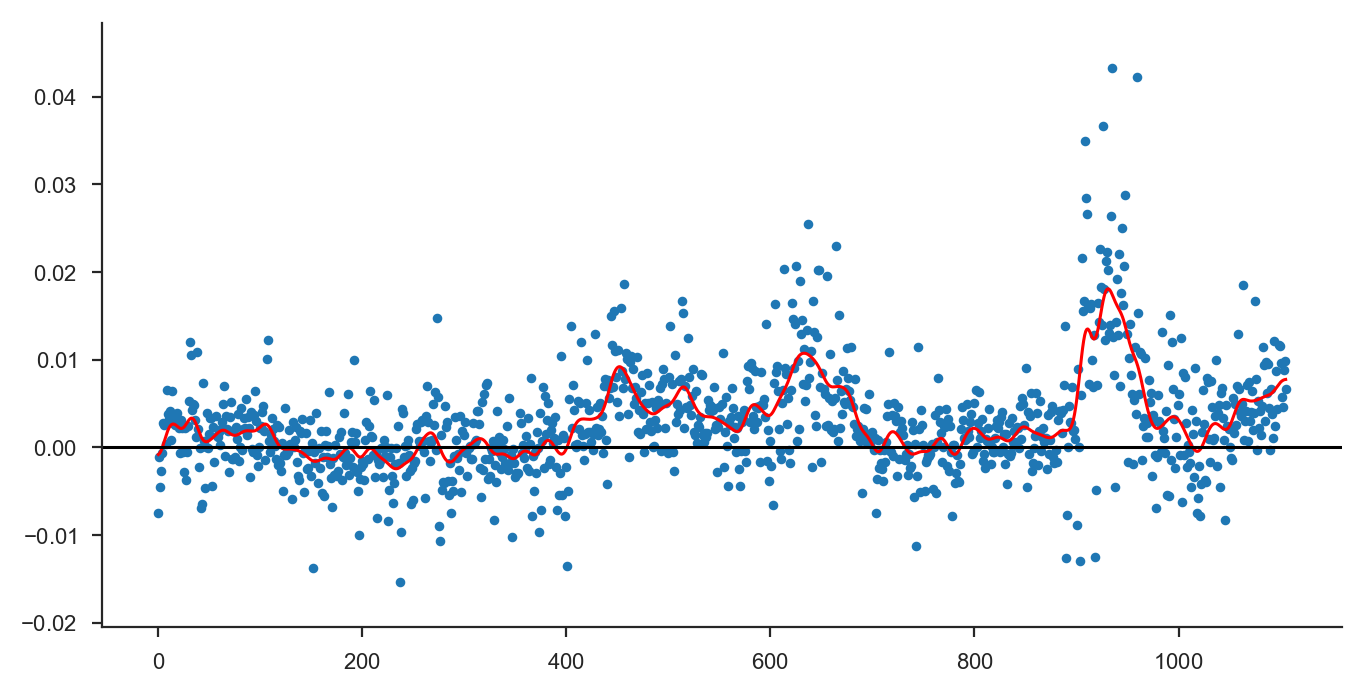

In [1050]:
from scipy.ndimage import gaussian_filter1d


y = barghi_tile_temp_covs[:, 0, 1, 0]
kern = gaussian_kde(y)


fig, ax = plt.subplots(figsize=(8, 4))
pos = np.arange(1106)
ax.scatter(pos, y, s=6)
ax.plot(pos, gaussian_filter1d(y, 6), c='r')
ax.axhline(0, c='k')

# def k_folds_cv(y, model, params, k=5):
#     breaks = np.linspace(1, len(y), k, dtype='int64')
#     k_folds = [slice(s, e) for s, e in zip(breaks[:-1], breaks[1:])]
#     scores = []
#     for param in params:
#         fold_scores = []
#         for i in range(k):
#             train_y = np.array([y[k_folds[j]] for j, fold in enumerate(k_folds) if j != i]).ravel()
#             test_y = y[k_folds[i]]
#             yhat = model(train_y, param)
#             fold_scores.append(((test_y - yhat)**2).mean())
#         scores.append(np.array(fold_scores).mean())
#     best_i = np.argmin(scores)
#     return best_i, params, scores

# i, vars, scores = k_folds_cv(y, gaussian_filter1d, np.linspace(0.5, 10, 20))

# Old Stuff

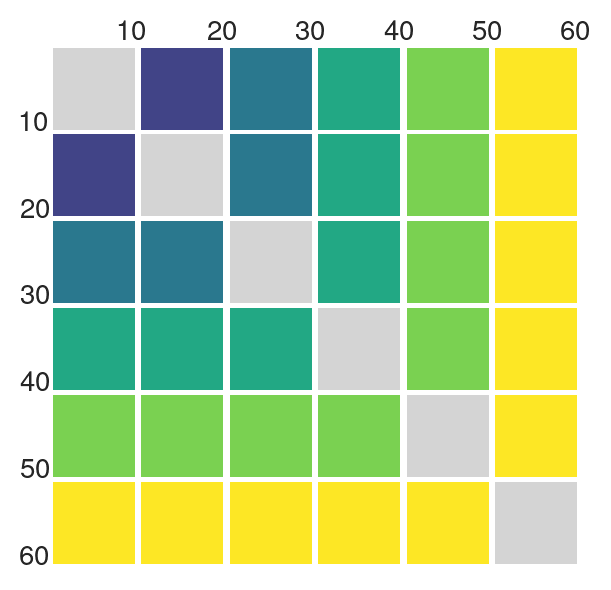

In [111]:
def make_grid(T):
    M = np.zeros((T, T))
    rows, cols = np.indices((T, T))
    for t in np.arange(T)[::-1]:
        M[(cols <= t) & (rows <= t)] = t
    np.fill_diagonal(M, np.nan)
    return M

#plt.imshow(make_grid(T))

# import matplotlib.gridspec as gridspec
# gs = gridspec.GridSpec(T, T)
# gs.update(wspace=0.01, hspace=0.04)

T = 6

fig, ax = plt.subplots(nrows=T, ncols=T, figsize=(ONECOL, ONECOL))
M = np.zeros((T, T))
rows, cols = np.indices((T, T))
bg_cols = cm.viridis(np.linspace(0, 1, T))

for t in np.arange(T)[::-1]:
    for r in np.arange(t):
        ax[r,t].set_facecolor(bg_cols[t])
        ax[t,r].set_facecolor(bg_cols[t])
    for r in np.arange(T):
        if r == t:
            ax[t,r].set_facecolor('44')
        ax[t, r].set_aspect('equal')
        ax[r, t].set_aspect('equal')
        
        ax[t, r].get_xaxis().set_visible(False)
        ax[r, t].get_xaxis().set_visible(False)
        ax[t, r].get_yaxis().set_visible(False)
        ax[t, r].get_yaxis().set_visible(False)
        
        ax[t, r].spines['top'].set_visible(False)
        ax[t, r].spines['right'].set_visible(False)
        ax[t, r].spines['left'].set_visible(False)
        ax[t, r].spines['bottom'].set_visible(False)
        if r == 0:
            ax[r, t].text(0.8, 1.1, (t+1)*10)
        if t == 0:
            ax[r, t].text(-0.4, 0, (r+1)*10)
plt.subplots_adjust(wspace=0.01, hspace=0.06)